## Packages

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from typing import Tuple
import sys
from pathlib import Path
from datetime import datetime
import os
import pyro

# Add parent directory to path to import Models
# This works for notebooks in the Experiments folder
project_root = Path.cwd().parent if Path.cwd().name == 'Experiments' else Path.cwd()
sys.path.insert(0, str(project_root))

# Setup results directory
results_dir = project_root / "results" / "sample_size"
results_dir.mkdir(parents=True, exist_ok=True)
plots_dir = results_dir / "plots"
plots_dir.mkdir(exist_ok=True)
stats_dir = results_dir / "statistics"
stats_dir.mkdir(exist_ok=True)

print(f"Results will be saved to: {results_dir}")

# Import from Models folder (note: no .py extension needed)
from Models.MC_Dropout import (
    MCDropoutRegressor,
    train_model,
    mc_dropout_predict,
    gaussian_nll,
    beta_nll,
    plot_toy_data,
    plot_uncertainties,
    normalize_x,
    normalize_x_data
)

from Models.Deep_Esemble import (
    train_ensemble_deep,
    ensemble_predict_deep
)

from Models.BNN import (
    train_bnn,
    bnn_predict,
    normalize_x as bnn_normalize_x,
    normalize_x_data as bnn_normalize_x_data
)

from Models.BAMLSS import (
    fit_bamlss,
    bamlss_predict
)

from utils.device import get_device
from utils.plotting import plot_toy_data, plot_uncertainties_no_ood
import utils.results_save as results_save_module
from utils.results_save import save_plot, save_statistics, save_summary_text, save_summary_statistics

# Set the module-level directories for results_save
results_save_module.plots_dir = plots_dir
results_save_module.stats_dir = stats_dir



Error importing in API mode: ImportError('On Windows, cffi mode "ANY" is only "ABI".')
Trying to import in ABI mode.


Results will be saved to: c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods-1\results\sample_size
CUDA not available. Using CPU.
CUDA not available. Using CPU.
CUDA not available. Using CPU.


In [4]:
device = get_device()

CUDA not available. Using CPU.


## Genarte toy data sets

In [11]:
# Reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# ----- Data generation for linear function with homo/heteroscedastic noise -----
# f(x) = 0.7x + 0.5
# noise_type: 'homoscedastic' (σ(x) = 0.20) or 'heteroscedastic' (σ(x) = 0.10 + 0.2(0.5 + 0.5sin(x)))
def generate_toy_regression(n_train=1000, train_range=(0.0, 10.0), 
                           grid_points=1000, noise_type='heteroscedastic', type = "linear"):
    low, high = train_range
    x_train = np.random.uniform(low, high, size=(n_train, 1))
    
    if type == "linear":
        # Linear function: f(x) = 0.7x + 0.5
        f_clean = lambda x: 0.7 * x + 0.5
        y_clean_train = f_clean(x_train)
    elif type == "sin":
        f_clean = lambda x:  x * np.sin(x) + x
        y_clean_train = f_clean(x_train)
    else:
        raise ValueError("type must be 'linear', 'sin'")

    # Define noise variance σ²(x)
    if noise_type == 'homoscedastic':
        # Homoscedastic: σ(x) = 0.8
        sigma = 2
        sigma_train = np.full_like(x_train, sigma)
    elif noise_type == 'heteroscedastic':
        # Heteroscedastic: 
        sigma_train = np.abs(2.5 * np.sin(0.5*x_train +5))
    else:
        raise ValueError("noise_type must be 'homoscedastic' or 'heteroscedastic'")
    
    # Generate noise: ε | x ~ N(0, σ²(x))
    epsilon = np.random.normal(0.0, sigma_train, size=(n_train, 1))
    y_train = y_clean_train + epsilon

    # Dense evaluation grid within training range
    x_grid = np.linspace(train_range[0], train_range[1], grid_points).reshape(-1, 1)
    y_grid_clean = f_clean(x_grid)

    return (x_train.astype(np.float32), y_train.astype(np.float32),
            x_grid.astype(np.float32), y_grid_clean.astype(np.float32))

In [12]:
# Polynomial function with homoscedastic noise
x_train_homo, y_train_homo, x_grid_homo, y_clean_homo = generate_toy_regression(
    n_train=2000, 
    train_range=(-5, 10), 
    noise_type='homoscedastic',
    type = "sin"
)

# Polynomial function with heteroscedastic noise (default - used in most experiments)
x_train, y_train, x_grid, y_clean = generate_toy_regression(
    n_train=2000, 
    train_range=(-5, 10), 
    noise_type='heteroscedastic',
    type = "sin"
)

Saved plot: c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods-1\results\sample_size\plots\toy_data\Toy_Regression_Data_Homescedastic_(n=1000).png


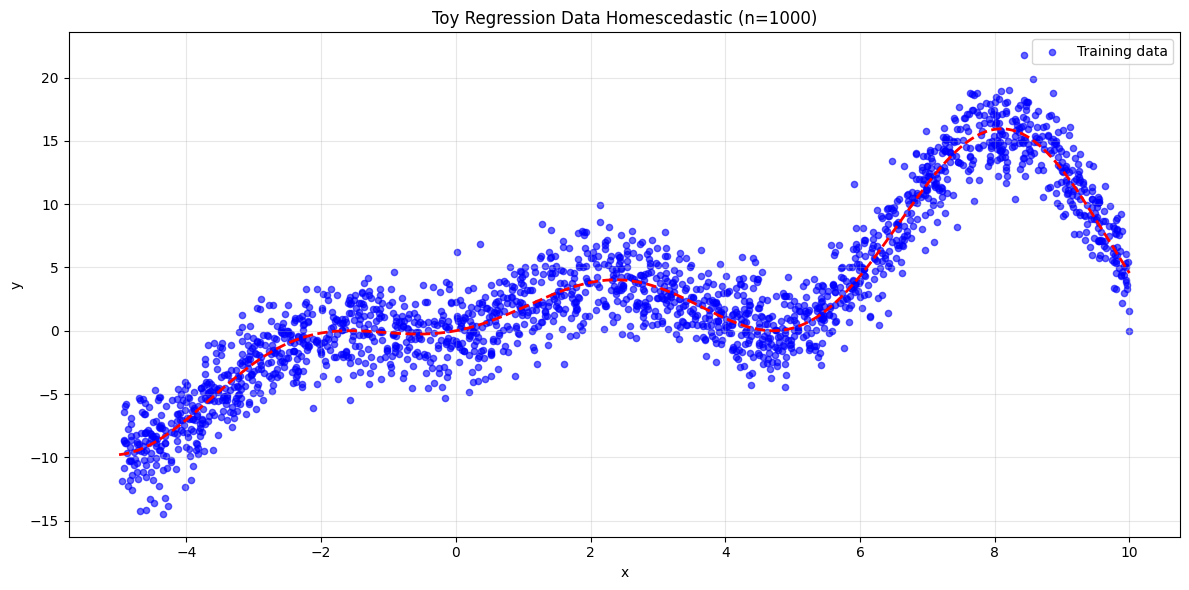

In [13]:
plot_toy_data(x_train_homo, y_train_homo, x_grid_homo, y_clean_homo, title="Toy Regression Data Homescedastic (n=1000)")

Saved plot: c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods-1\results\sample_size\plots\toy_data\Toy_Regression_Data_Heteroscedastic_(n=1000).png


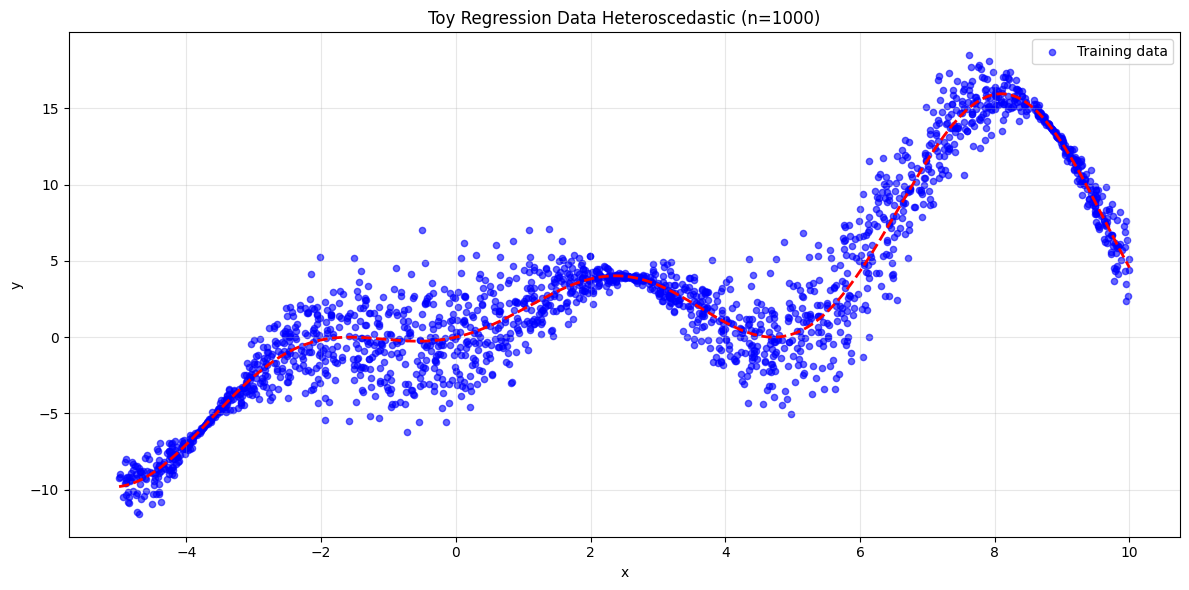

In [14]:
plot_toy_data(x_train, y_train, x_grid, y_clean, title="Toy Regression Data Heteroscedastic (n=1000)")

## Sample size Heteroscedastic MC Droput


################################################################################
# Function Type: Linear (linear)
################################################################################


Training with 50% of training data (500 samples)
CUDA not available. Using CPU.
[beta_nll] Epoch 100/700 - avg loss 1.3907
[beta_nll] Epoch 200/700 - avg loss 1.3285
[beta_nll] Epoch 300/700 - avg loss 1.3532
[beta_nll] Epoch 400/700 - avg loss 1.3611
[beta_nll] Epoch 500/700 - avg loss 1.3685
[beta_nll] Epoch 600/700 - avg loss 1.3806
[beta_nll] Epoch 700/700 - avg loss 1.3681
CUDA not available. Using CPU.
Saved plot: c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods-1\results\sample_size\plots\uncertainties\heteroscedastic\linear\MC_Dropout_(β-NLL,_β=0.5)_-_Linear_-_50%_training_data.png


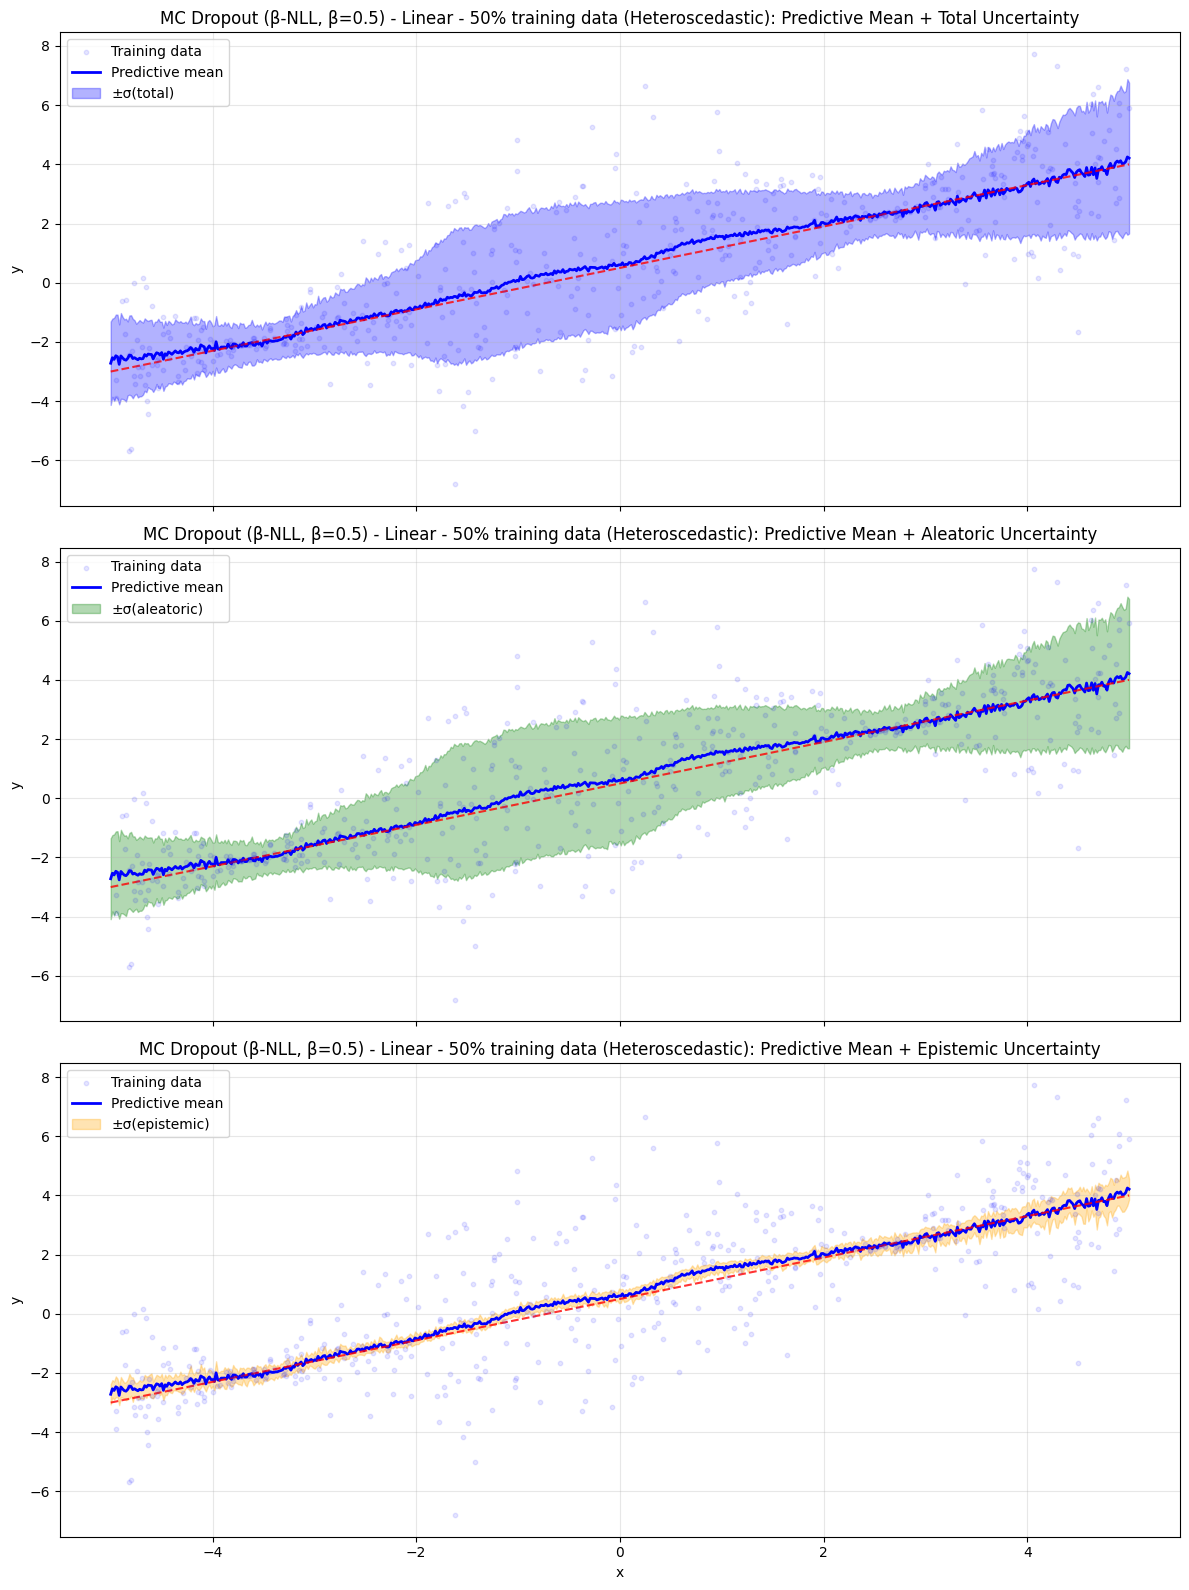


Normalized Average Uncertainties by Percentage - Linear Function

Percentage   Avg Aleatoric (norm)      Avg Epistemic (norm)      Avg Total (norm)          Correlation (Epi-Ale)    
------------------------------------------------------------------------------------------------------------------------
 50%                        0.342710                  0.140382                  0.483091                  0.125050

Note: Average values are normalized to [0, 1] range across all percentages
      Correlation is computed on original (non-normalized) uncertainty values
Saved statistics (CSV): c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods-1\results\sample_size\statistics\heteroscedastic\linear\MC_Dropout_uncertainties_summary_Linear_heteroscedastic.csv
Saved statistics (Excel): c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods-1\results\sample_size\statistics

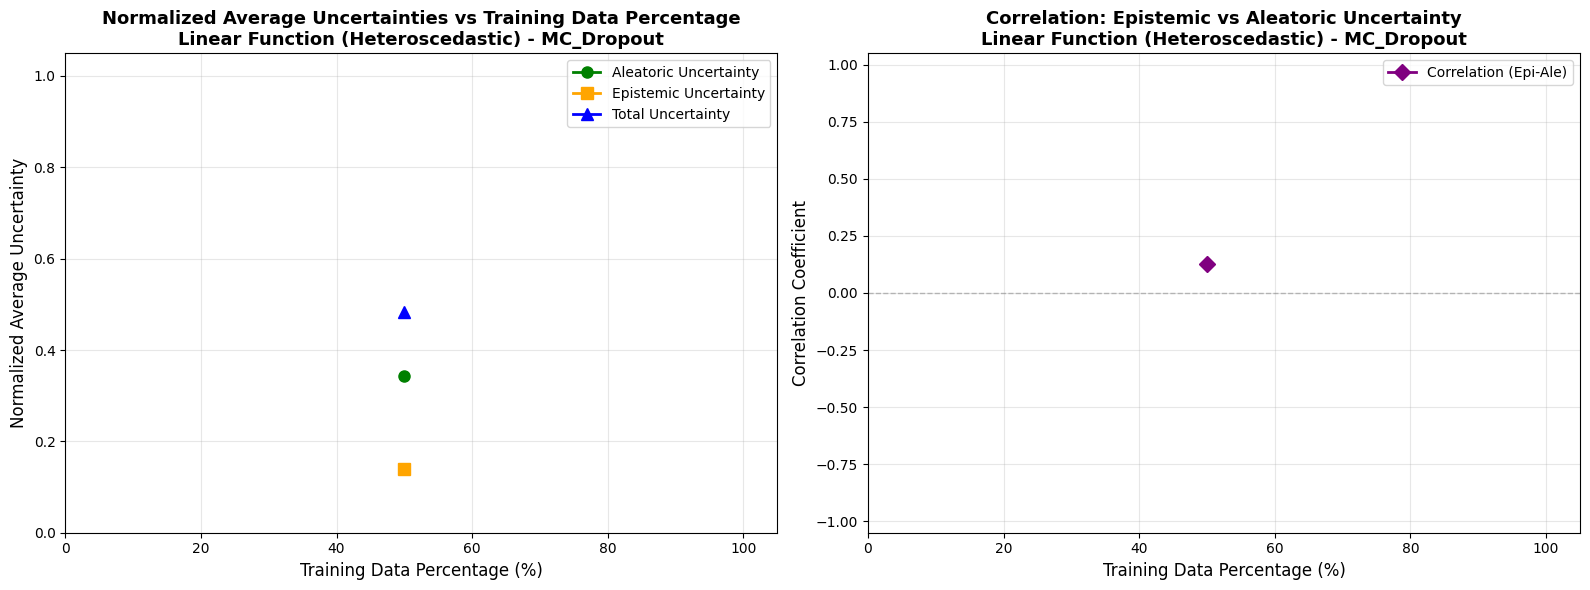


################################################################################
# Function Type: Sinusoidal (sin)
################################################################################


Training with 50% of training data (500 samples)
CUDA not available. Using CPU.
[beta_nll] Epoch 100/700 - avg loss 1.8296
[beta_nll] Epoch 200/700 - avg loss 1.5954
[beta_nll] Epoch 300/700 - avg loss 1.5951
[beta_nll] Epoch 400/700 - avg loss 1.5227
[beta_nll] Epoch 500/700 - avg loss 1.4993
[beta_nll] Epoch 600/700 - avg loss 1.5208
[beta_nll] Epoch 700/700 - avg loss 1.4274
CUDA not available. Using CPU.
Saved plot: c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods-1\results\sample_size\plots\uncertainties\heteroscedastic\sin\MC_Dropout_(β-NLL,_β=0.5)_-_Sinusoidal_-_50%_training_data.png


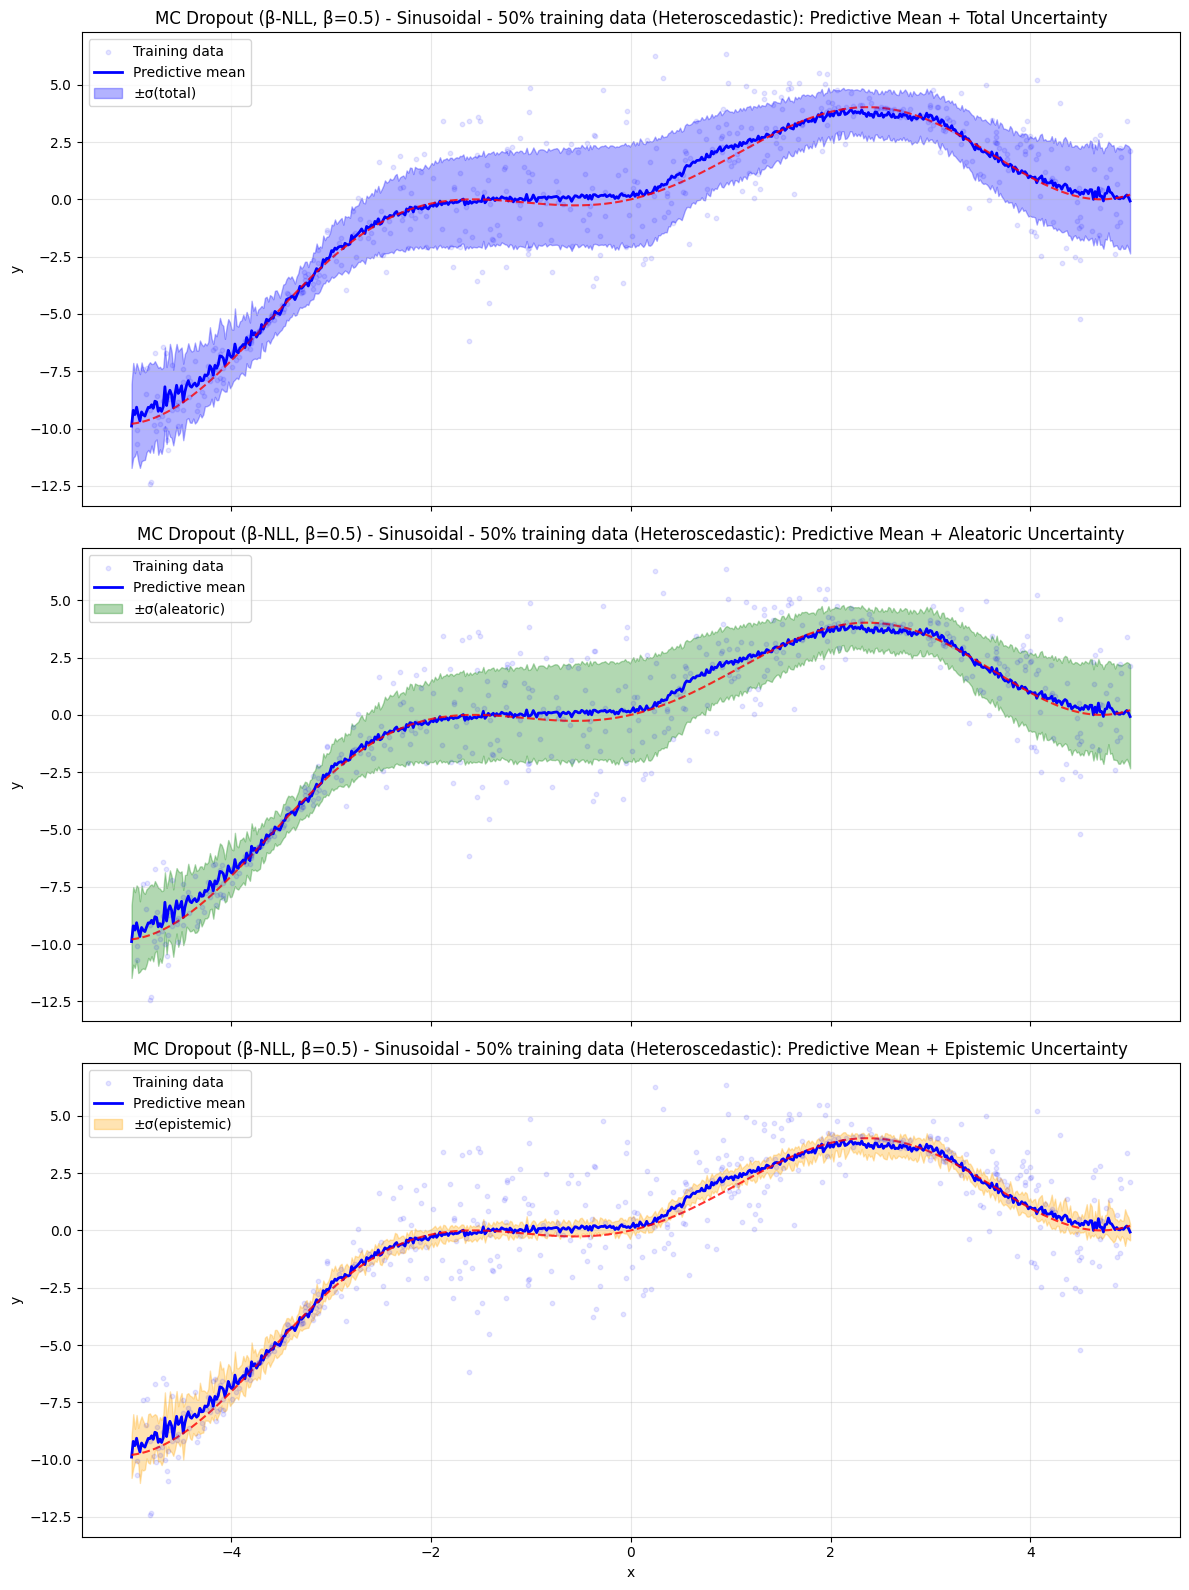


Normalized Average Uncertainties by Percentage - Sinusoidal Function

Percentage   Avg Aleatoric (norm)      Avg Epistemic (norm)      Avg Total (norm)          Correlation (Epi-Ale)    
------------------------------------------------------------------------------------------------------------------------
 50%                        0.436543                  0.122564                  0.559107                 -0.208808

Note: Average values are normalized to [0, 1] range across all percentages
      Correlation is computed on original (non-normalized) uncertainty values
Saved statistics (CSV): c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods-1\results\sample_size\statistics\heteroscedastic\sin\MC_Dropout_uncertainties_summary_Sinusoidal_heteroscedastic.csv
Saved statistics (Excel): c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods-1\results\sample_size\stati

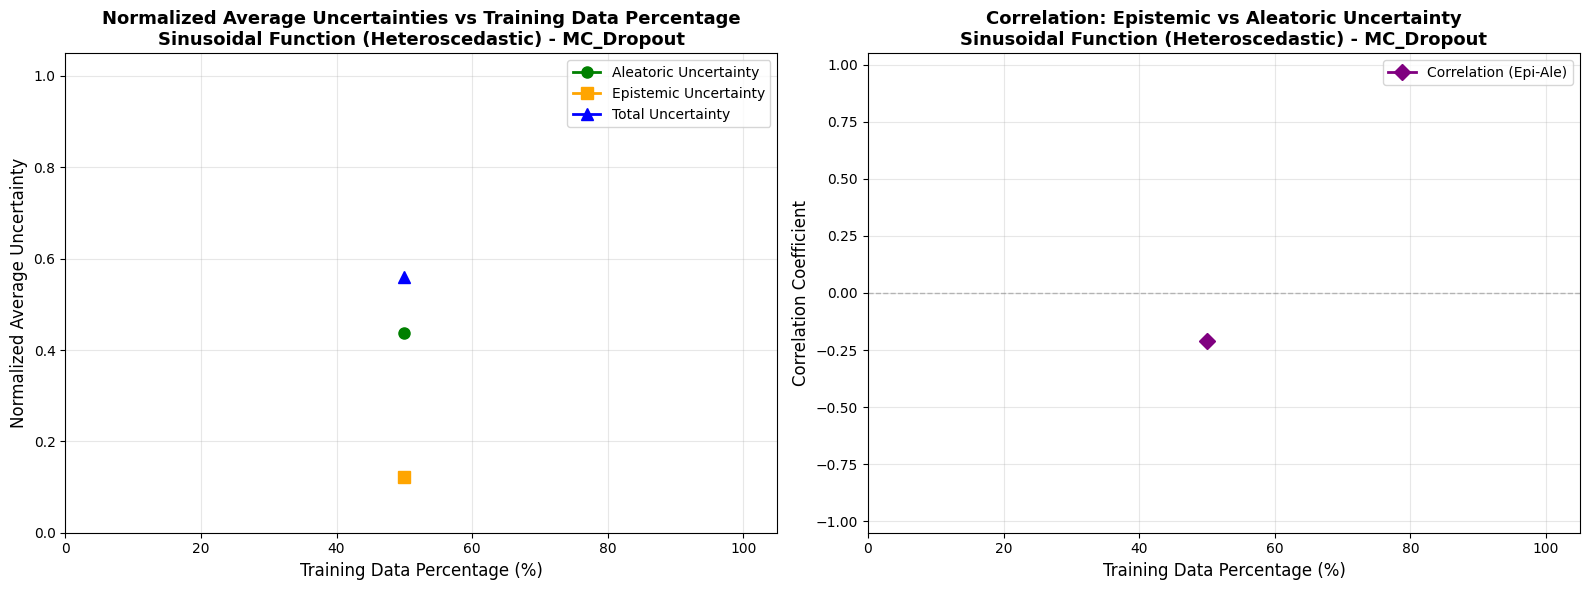

In [ ]:
# Loop through different function types: linear, non-linear, sin
function_types = ["linear", "sin"]
function_names = {"linear": "Linear", "sin": "Sinusoidal"}

for func_type in function_types:
    print(f"\n{'#'*80}")
    print(f"# Function Type: {function_names[func_type]} ({func_type})")
    print(f"{'#'*80}\n")
    
    # Loop through different training data amounts: 1%, 5%, 10%, 15%, 50%, 100%
    # Generate full training dataset using generate_toy_regression function
    np.random.seed(42)
    torch.manual_seed(42)

    # Generate training dataset
    x_train_full, y_train_full, x_grid, y_grid_clean = generate_toy_regression(
        n_train=1000, 
        train_range=(-5, 10), 
        grid_points=1000,
        noise_type='heteroscedastic',
        type=func_type
    )

    # Training data percentages to test
    percentages = [50]
      
    # Main loop: train and evaluate for each percentage
    n_train_full = len(x_train_full)

    # Store uncertainties for each percentage
    uncertainties_by_pct = {pct: {'ale': [], 'epi': [], 'tot': []} for pct in percentages}

    for pct in percentages:
        print(f"\n{'='*60}")
        print(f"Training with {pct}% of training data ({int(n_train_full * pct / 100)} samples)")
        print(f"{'='*60}")
        
        # Set seed for reproducibility of subsampling and training
        np.random.seed(42)
        torch.manual_seed(42)
        
        # Subsample training data
        n_samples = int(n_train_full * pct / 100)
        indices = np.random.choice(n_train_full, size=n_samples, replace=False)
        x_train_subset = x_train_full[indices]
        y_train_subset = y_train_full[indices]
        
        # Normalize input x (y stays in original scale)
        x_mean, x_std = normalize_x(x_train_subset)
        x_train_subset_norm = normalize_x_data(x_train_subset, x_mean, x_std)
        x_grid_norm = normalize_x_data(x_grid, x_mean, x_std)
        
        # Create dataloader with normalized x (y stays in original scale)
        ds = TensorDataset(torch.from_numpy(x_train_subset_norm), torch.from_numpy(y_train_subset))
        loader = DataLoader(ds, batch_size=32, shuffle=True)
        
        # Train MC Dropout model with beta-NLL (β=0.5)
        model = MCDropoutRegressor(p=0.2)
        train_model(model, loader, epochs=700, lr=1e-3, loss_type='beta_nll', beta=0.5)
        
        # Make predictions using normalized x_grid (predictions are in original y scale)
        mu_pred, ale_var, epi_var, tot_var = mc_dropout_predict(model, x_grid_norm, M=20)
        
        # Store uncertainties (using variance values)
        uncertainties_by_pct[pct]['ale'].append(ale_var)
        uncertainties_by_pct[pct]['epi'].append(epi_var)
        uncertainties_by_pct[pct]['tot'].append(tot_var)
        
        # Plot uncertainties (original absolute units plot)
        plot_uncertainties_no_ood(x_train_subset, y_train_subset, x_grid, y_grid_clean, 
                                 mu_pred, ale_var, epi_var, tot_var, 
                                 title=f"MC Dropout (β-NLL, β=0.5) - {function_names[func_type]} - {pct}% training data",
                                 noise_type='heteroscedastic', func_type=func_type)
    

    # Normalize and compute averages for each percentage
    print(f"\n{'='*60}")
    print(f"Normalized Average Uncertainties by Percentage - {function_names[func_type]} Function")
    print(f"{'='*60}")

    # First, collect all values to compute global min/max for normalization
    all_ale = np.concatenate([np.concatenate(uncertainties_by_pct[pct]['ale']) for pct in percentages])
    all_epi = np.concatenate([np.concatenate(uncertainties_by_pct[pct]['epi']) for pct in percentages])
    

    # Compute min and max for normalization
    ale_min, ale_max = all_ale.min(), all_ale.max()
    epi_min, epi_max = all_epi.min(), all_epi.max()
    


    # Normalize function
    def normalize(values, vmin, vmax):
        """Normalize values to [0, 1] range"""
        if vmax - vmin == 0:
            return np.zeros_like(values)
        return (values - vmin) / (vmax - vmin)

    # Compute and print normalized averages and correlations for each percentage
    print(f"\n{'Percentage':<12} {'Avg Aleatoric (norm)':<25} {'Avg Epistemic (norm)':<25} {'Avg Total (norm)':<25} {'Correlation (Epi-Ale)':<25}")
    print("-" * 120)

    # Store averages and correlations for plotting
    avg_ale_norm_list = []
    avg_epi_norm_list = []
    avg_tot_norm_list = []
    correlation_list = []

    for pct in percentages:
        # Get uncertainties for this percentage
        ale_vals = np.concatenate(uncertainties_by_pct[pct]['ale'])
        epi_vals = np.concatenate(uncertainties_by_pct[pct]['epi'])
        tot_vals = np.concatenate(uncertainties_by_pct[pct]['tot'])
        
        # Normalize
        ale_norm = normalize(ale_vals, ale_min, ale_max)
        epi_norm = normalize(epi_vals, epi_min, epi_max)
        tot_norm = ale_norm + epi_norm
        
        # Compute averages
        avg_ale_norm = np.mean(ale_norm)
        avg_epi_norm = np.mean(epi_norm)
        avg_tot_norm = np.mean(tot_norm)
        
        # Compute correlation between epistemic and aleatoric uncertainties
        # Use original (non-normalized) values for correlation
        correlation = np.corrcoef(epi_vals, ale_vals)[0, 1]
        if np.isnan(correlation):
            correlation = 0.0  # Handle case where std is zero
        
        # Store for plotting
        avg_ale_norm_list.append(avg_ale_norm)
        avg_epi_norm_list.append(avg_epi_norm)
        avg_tot_norm_list.append(avg_tot_norm)
        correlation_list.append(correlation)
        
        print(f"{pct:>3}%        {avg_ale_norm:>24.6f}  {avg_epi_norm:>24.6f}  {avg_tot_norm:>24.6f}  {correlation:>24.6f}")

    print(f"\n{'='*60}")
    print("Note: Average values are normalized to [0, 1] range across all percentages")
    print("      Correlation is computed on original (non-normalized) uncertainty values")
    print(f"{'='*60}")

    # Save summary statistics and create summary plot
    stats_df, fig = save_summary_statistics(
        percentages, avg_ale_norm_list, avg_epi_norm_list, 
        avg_tot_norm_list, correlation_list, 
        function_names[func_type], 
        noise_type='heteroscedastic',
        func_type=func_type,
        model_name='MC_Dropout'
    )
    plt.show()
    plt.close(fig)

## Smaple size Homoscedastic MC Dropout


################################################################################
# Function Type: Linear (linear)
################################################################################


Training with 5% of training data (50 samples)
CUDA not available. Using CPU.
[beta_nll] Epoch 100/700 - avg loss 6.8120
[beta_nll] Epoch 200/700 - avg loss 7.0647
[beta_nll] Epoch 300/700 - avg loss 5.9573
[beta_nll] Epoch 400/700 - avg loss 5.6753
[beta_nll] Epoch 500/700 - avg loss 5.0829
[beta_nll] Epoch 600/700 - avg loss 5.0435
[beta_nll] Epoch 700/700 - avg loss 4.8416
CUDA not available. Using CPU.
Saved plot: c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods-1\results\sample_size\plots\uncertainties\homoscedastic\linear\MC_Dropout_(β-NLL,_β=0.5)_-_Linear_-_5%_training_data.png


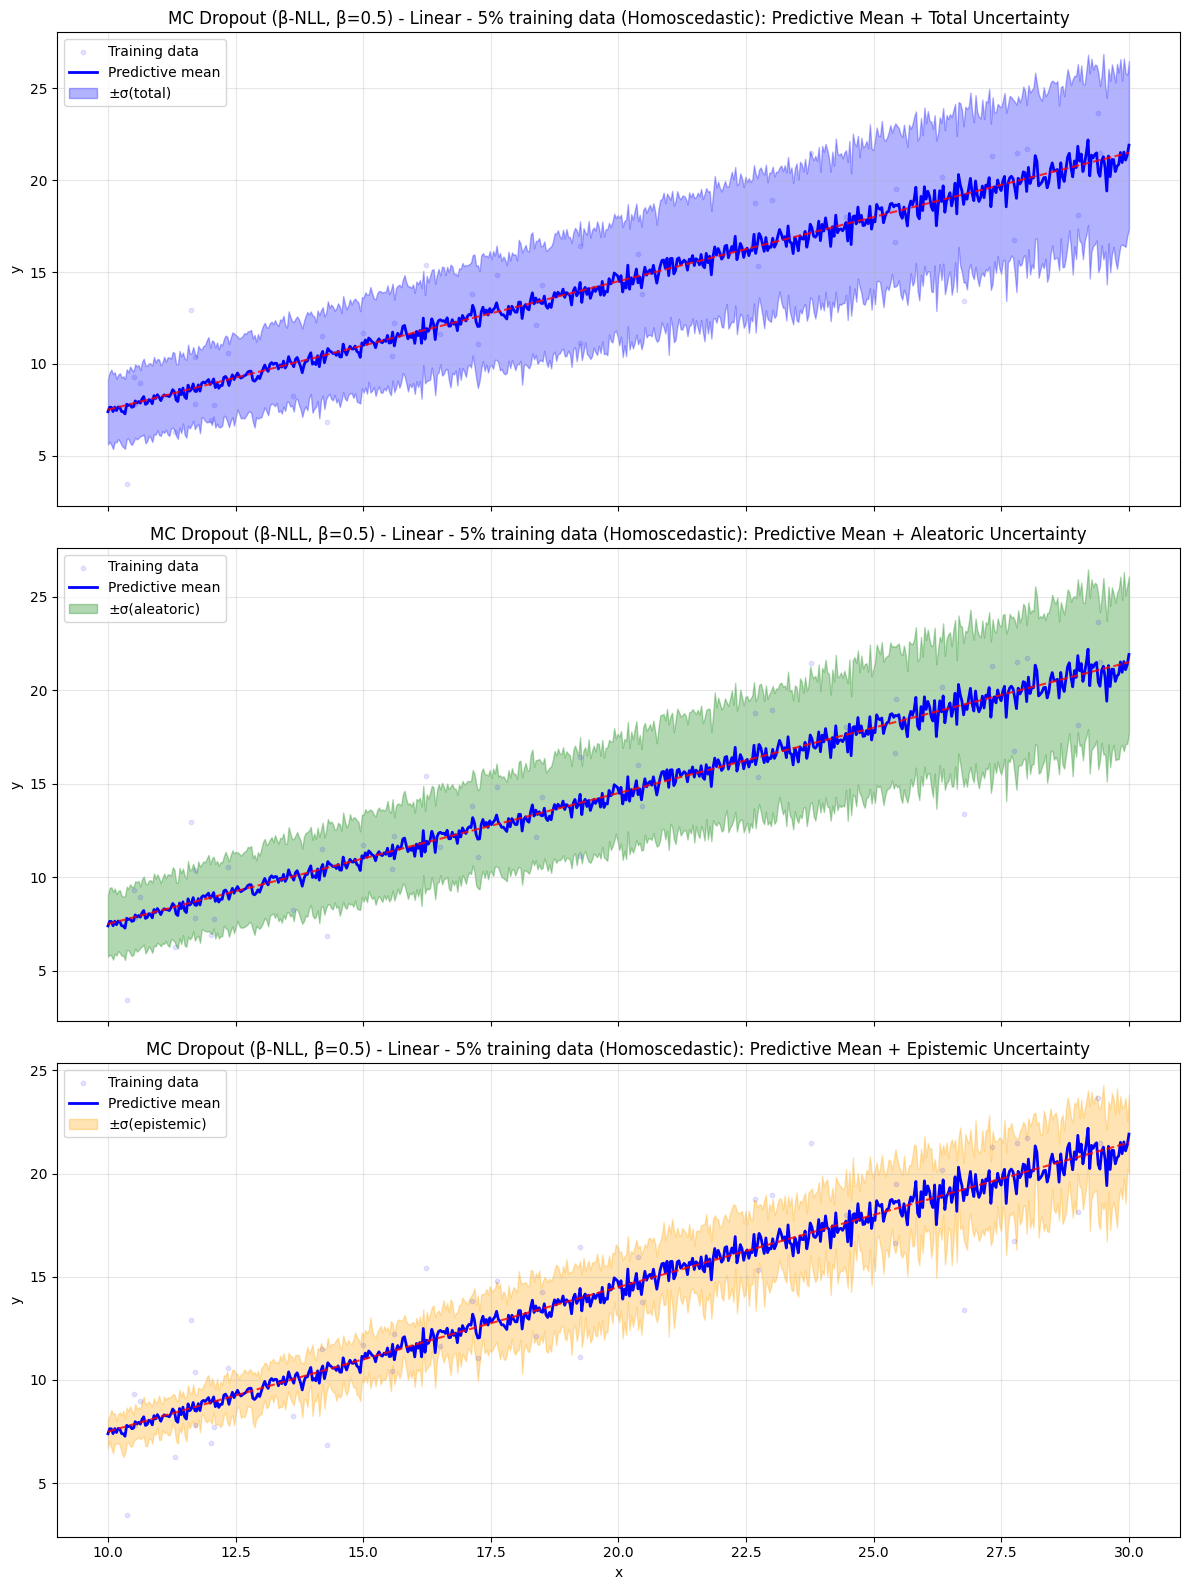


Training with 10% of training data (100 samples)
CUDA not available. Using CPU.
[beta_nll] Epoch 100/700 - avg loss 6.8179
[beta_nll] Epoch 200/700 - avg loss 4.9875
[beta_nll] Epoch 300/700 - avg loss 4.5206
[beta_nll] Epoch 400/700 - avg loss 4.6338
[beta_nll] Epoch 500/700 - avg loss 3.5532
[beta_nll] Epoch 600/700 - avg loss 4.0838
[beta_nll] Epoch 700/700 - avg loss 3.2354
CUDA not available. Using CPU.
Saved plot: c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods-1\results\sample_size\plots\uncertainties\homoscedastic\linear\MC_Dropout_(β-NLL,_β=0.5)_-_Linear_-_10%_training_data.png


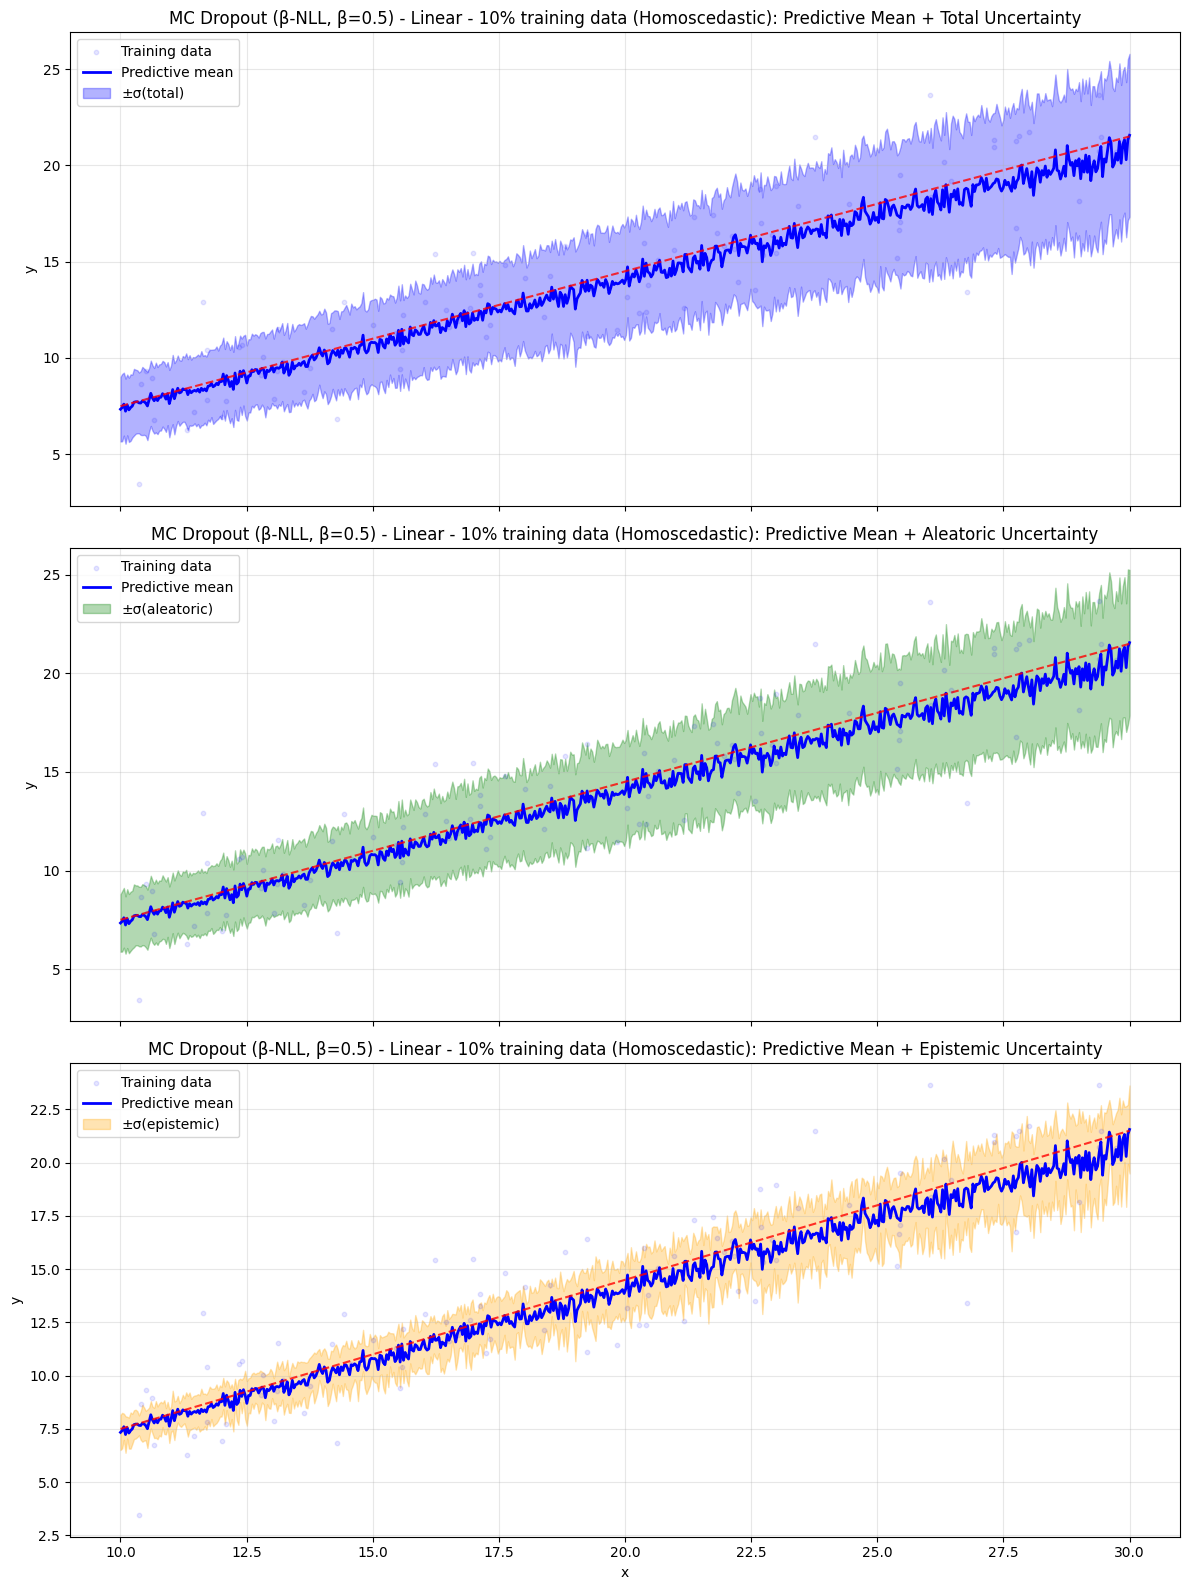


Training with 15% of training data (150 samples)
CUDA not available. Using CPU.
[beta_nll] Epoch 100/700 - avg loss 6.9202
[beta_nll] Epoch 200/700 - avg loss 4.9735
[beta_nll] Epoch 300/700 - avg loss 3.7452
[beta_nll] Epoch 400/700 - avg loss 3.5356
[beta_nll] Epoch 500/700 - avg loss 3.4651
[beta_nll] Epoch 600/700 - avg loss 3.7166
[beta_nll] Epoch 700/700 - avg loss 3.4444
CUDA not available. Using CPU.
Saved plot: c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods-1\results\sample_size\plots\uncertainties\homoscedastic\linear\MC_Dropout_(β-NLL,_β=0.5)_-_Linear_-_15%_training_data.png


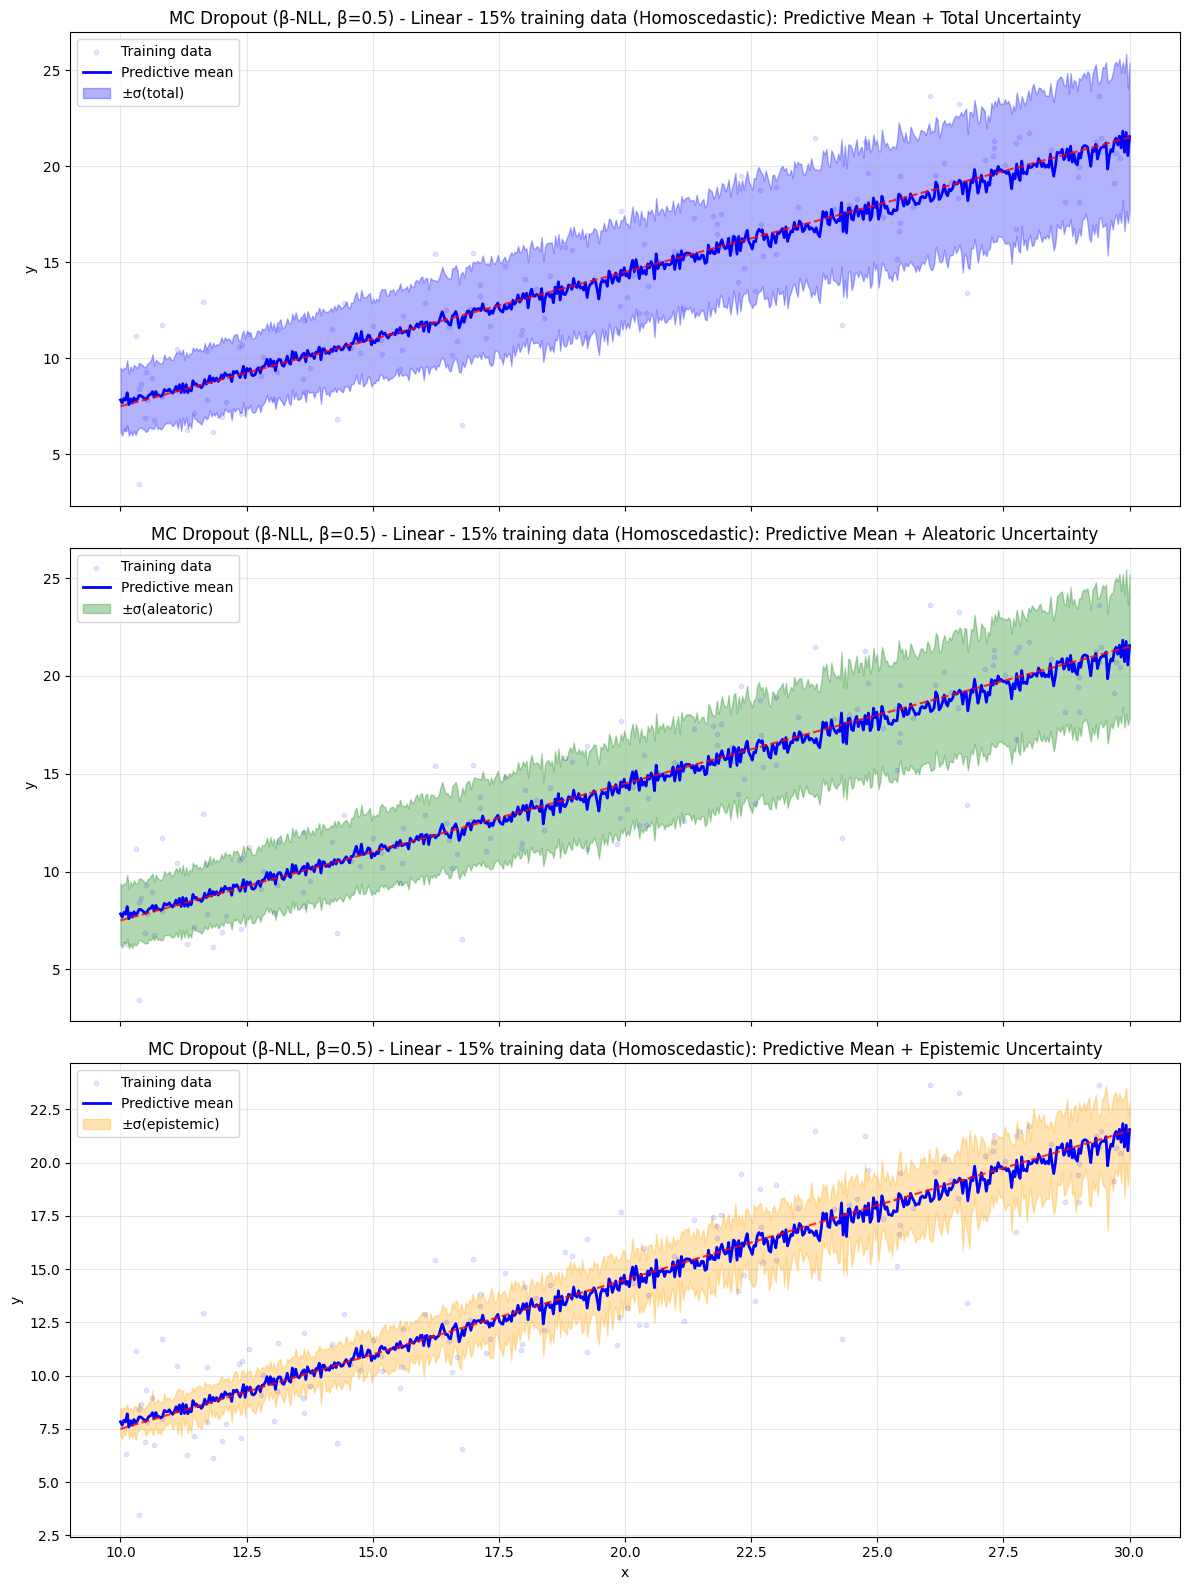


Training with 25% of training data (250 samples)
CUDA not available. Using CPU.
[beta_nll] Epoch 100/700 - avg loss 5.0468
[beta_nll] Epoch 200/700 - avg loss 3.8280
[beta_nll] Epoch 300/700 - avg loss 3.1098
[beta_nll] Epoch 400/700 - avg loss 3.4179
[beta_nll] Epoch 500/700 - avg loss 3.2651
[beta_nll] Epoch 600/700 - avg loss 2.9995
[beta_nll] Epoch 700/700 - avg loss 2.9609
CUDA not available. Using CPU.
Saved plot: c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods-1\results\sample_size\plots\uncertainties\homoscedastic\linear\MC_Dropout_(β-NLL,_β=0.5)_-_Linear_-_25%_training_data.png


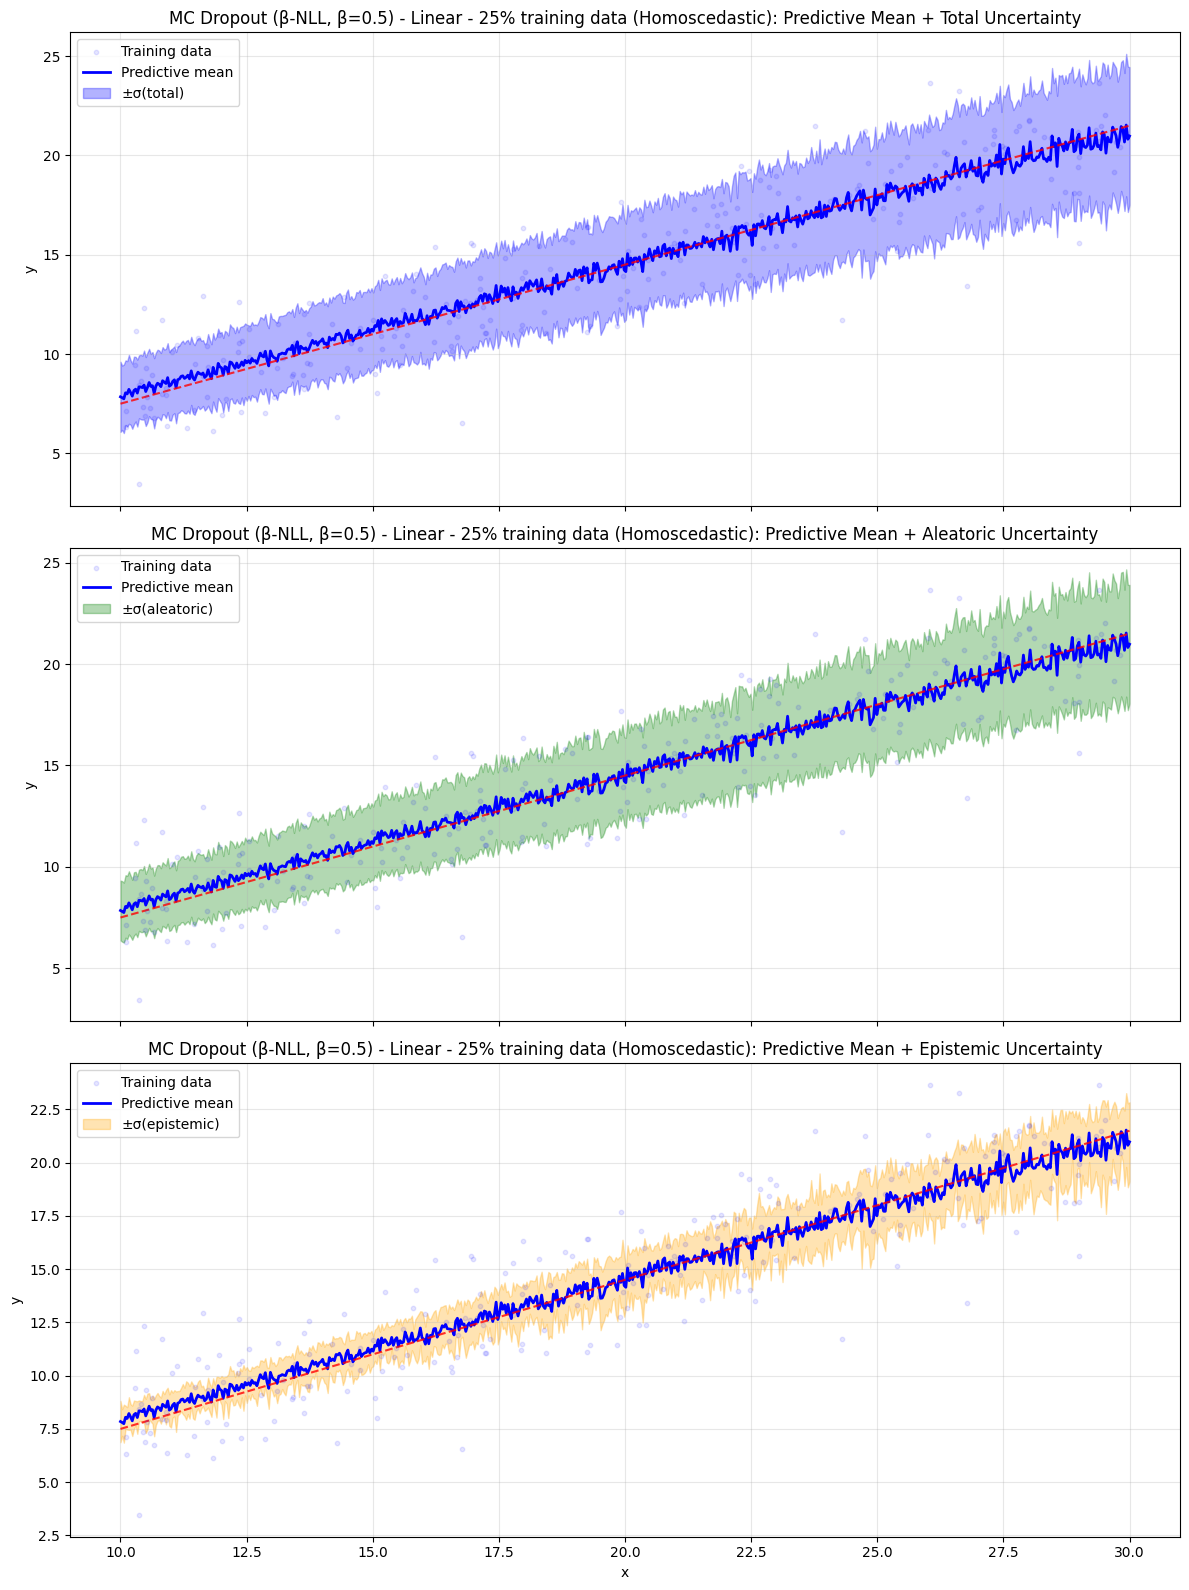


Training with 50% of training data (500 samples)
CUDA not available. Using CPU.


In [ ]:
# Loop through different function types: linear, non-linear, sin
function_types = ["linear", "sin"]
function_names = {"linear": "Linear", "sin": "Sinusoidal"}

for func_type in function_types:
    print(f"\n{'#'*80}")
    print(f"# Function Type: {function_names[func_type]} ({func_type})")
    print(f"{'#'*80}\n")
    
    # Loop through different training data amounts: 1%, 5%, 10%, 15%, 50%, 100%
    # Generate full training dataset using generate_toy_regression function
    np.random.seed(42)
    torch.manual_seed(42)

    # Generate training dataset
    x_train_full, y_train_full, x_grid, y_grid_clean = generate_toy_regression(
        n_train=1000, 
        train_range=(-5, 10), 
        grid_points=1000,
        noise_type='homoscedastic',
        type=func_type
    )

    # Training data percentages to test
    percentages = [5, 10, 15, 25, 50, 100]
      
    # Main loop: train and evaluate for each percentage
    n_train_full = len(x_train_full)

    # Store uncertainties for each percentage
    uncertainties_by_pct = {pct: {'ale': [], 'epi': [], 'tot': []} for pct in percentages}

    for pct in percentages:
        print(f"\n{'='*60}")
        print(f"Training with {pct}% of training data ({int(n_train_full * pct / 100)} samples)")
        print(f"{'='*60}")
        
        # Set seed for reproducibility of subsampling and training
        np.random.seed(42)
        torch.manual_seed(42)
        
        # Subsample training data
        n_samples = int(n_train_full * pct / 100)
        indices = np.random.choice(n_train_full, size=n_samples, replace=False)
        x_train_subset = x_train_full[indices]
        y_train_subset = y_train_full[indices]
        
        # Create dataloader
        ds = TensorDataset(torch.from_numpy(x_train_subset), torch.from_numpy(y_train_subset))
        loader = DataLoader(ds, batch_size=32, shuffle=True)
        
        # Train MC Dropout model with beta-NLL (β=0.5)
        model = MCDropoutRegressor(p=0.2)
        train_model(model, loader, epochs=700, lr=1e-3, loss_type='beta_nll', beta=0.5)
        
        # Make predictions
        mu_pred, ale_var, epi_var, tot_var = mc_dropout_predict(model, x_grid, M=20)
        
        # Store uncertainties (using variance values)
        uncertainties_by_pct[pct]['ale'].append(ale_var)
        uncertainties_by_pct[pct]['epi'].append(epi_var)
        uncertainties_by_pct[pct]['tot'].append(tot_var)
    
        # Plot uncertainties
        plot_uncertainties_no_ood(x_train_subset, y_train_subset, x_grid, y_grid_clean, 
                                 mu_pred, ale_var, epi_var, tot_var, 
                                 title=f"MC Dropout (β-NLL, β=0.5) - {function_names[func_type]} - {pct}% training data",
                                 noise_type='homoscedastic', func_type=func_type)

    # Normalize and compute averages for each percentage
    print(f"\n{'='*60}")
    print(f"Normalized Average Uncertainties by Percentage - {function_names[func_type]} Function")
    print(f"{'='*60}")

    # First, collect all values to compute global min/max for normalization
    all_ale = np.concatenate([np.concatenate(uncertainties_by_pct[pct]['ale']) for pct in percentages])
    all_epi = np.concatenate([np.concatenate(uncertainties_by_pct[pct]['epi']) for pct in percentages])
    all_tot = np.concatenate([np.concatenate(uncertainties_by_pct[pct]['tot']) for pct in percentages])

    # Compute min and max for normalization
    ale_min, ale_max = all_ale.min(), all_ale.max()
    epi_min, epi_max = all_epi.min(), all_epi.max()
    tot_min, tot_max = all_tot.min(), all_tot.max()

    # Normalize function
    def normalize(values, vmin, vmax):
        """Normalize values to [0, 1] range"""
        if vmax - vmin == 0:
            return np.zeros_like(values)
        return (values - vmin) / (vmax - vmin)

    # Compute and print normalized averages and correlations for each percentage
    print(f"\n{'Percentage':<12} {'Avg Aleatoric (norm)':<25} {'Avg Epistemic (norm)':<25} {'Avg Total (norm)':<25} {'Correlation (Epi-Ale)':<25}")
    print("-" * 120)

    # Store averages and correlations for plotting
    avg_ale_norm_list = []
    avg_epi_norm_list = []
    avg_tot_norm_list = []
    correlation_list = []

    for pct in percentages:
        # Get uncertainties for this percentage
        ale_vals = np.concatenate(uncertainties_by_pct[pct]['ale'])
        epi_vals = np.concatenate(uncertainties_by_pct[pct]['epi'])
        tot_vals = np.concatenate(uncertainties_by_pct[pct]['tot'])
        
        # Normalize
        ale_norm = normalize(ale_vals, ale_min, ale_max)
        epi_norm = normalize(epi_vals, epi_min, epi_max)
        tot_norm = ale_norm + epi_norm
        
        # Compute averages
        avg_ale_norm = np.mean(ale_norm)
        avg_epi_norm = np.mean(epi_norm)
        avg_tot_norm = np.mean(tot_norm)
        
        # Compute correlation between epistemic and aleatoric uncertainties
        # Use original (non-normalized) values for correlation
        correlation = np.corrcoef(epi_vals, ale_vals)[0, 1]
        if np.isnan(correlation):
            correlation = 0.0  # Handle case where std is zero
        
        # Store for plotting
        avg_ale_norm_list.append(avg_ale_norm)
        avg_epi_norm_list.append(avg_epi_norm)
        avg_tot_norm_list.append(avg_tot_norm)
        correlation_list.append(correlation)
    
        print(f"{pct:>3}%        {avg_ale_norm:>24.6f}  {avg_epi_norm:>24.6f}  {avg_tot_norm:>24.6f}  {correlation:>24.6f}")

    print(f"\n{'='*60}")
    print("Note: Average values are normalized to [0, 1] range across all percentages")
    print("      Correlation is computed on original (non-normalized) uncertainty values")
    print(f"{'='*60}")

    # Save summary statistics and create summary plot
    stats_df, fig = save_summary_statistics(
        percentages, avg_ale_norm_list, avg_epi_norm_list, 
        avg_tot_norm_list, correlation_list, 
        function_names[func_type], 
        noise_type='homoscedastic',
        func_type=func_type,
        model_name='MC_Dropout'
    )
    plt.show()
    plt.close(fig)

## Sample size Heteroscedastic - Deep Ensemble


In [ ]:
# Loop through different function types: linear, sin
function_types = ["linear", "sin"]
function_names = {"linear": "Linear", "sin": "Sinusoidal"}

for func_type in function_types:
    print(f"\n{'#'*80}")
    print(f"# Function Type: {function_names[func_type]} ({func_type}) - Deep Ensemble")
    print(f"{'#'*80}\n")
    
    # Loop through different training data amounts: 1%, 5%, 10%, 15%, 50%, 100%
    # Generate full training dataset using generate_toy_regression function
    np.random.seed(42)
    torch.manual_seed(42)

    # Generate training dataset
    x_train_full, y_train_full, x_grid, y_grid_clean = generate_toy_regression(
        n_train=1000, 
        train_range=(-5, 10), 
        grid_points=1000,
        noise_type='heteroscedastic',
        type=func_type
    )

    # Training data percentages to test
    percentages = [5, 10, 15, 25, 50, 100]
      
    # Main loop: train and evaluate for each percentage
    n_train_full = len(x_train_full)

    # Store uncertainties for each percentage
    uncertainties_by_pct = {pct: {'ale': [], 'epi': [], 'tot': []} for pct in percentages}

    for pct in percentages:
        print(f"\n{'='*60}")
        print(f"Training with {pct}% of training data ({int(n_train_full * pct / 100)} samples)")
        print(f"{'='*60}")
        
        # Set seed for reproducibility of subsampling and training
        np.random.seed(42)
        torch.manual_seed(42)
        
        # Subsample training data
        n_samples = int(n_train_full * pct / 100)
        indices = np.random.choice(n_train_full, size=n_samples, replace=False)
        x_train_subset = x_train_full[indices]
        y_train_subset = y_train_full[indices]
        
        # Normalize input x (y stays in original scale)
        x_mean, x_std = normalize_x(x_train_subset)
        x_train_subset_norm = normalize_x_data(x_train_subset, x_mean, x_std)
        x_grid_norm = normalize_x_data(x_grid, x_mean, x_std)
        
        # Train Deep Ensemble with beta-NLL (β=0.5)
        ensemble = train_ensemble_deep(x_train_subset_norm, y_train_subset, batch_size=32, K=5, loss_type='beta_nll', beta=0.5)
        
        # Make predictions using normalized x_grid (predictions are in original y scale)
        mu_pred, ale_var, epi_var, tot_var = ensemble_predict_deep(ensemble, x_grid_norm)
        
        # Store uncertainties (using variance values)
        uncertainties_by_pct[pct]['ale'].append(ale_var)
        uncertainties_by_pct[pct]['epi'].append(epi_var)
        uncertainties_by_pct[pct]['tot'].append(tot_var)
        
        # Plot uncertainties (original absolute units plot)
        plot_uncertainties_no_ood(x_train_subset, y_train_subset, x_grid, y_grid_clean, 
                                 mu_pred, ale_var, epi_var, tot_var, 
                                 title=f"Deep Ensemble (β-NLL, β=0.5) - {function_names[func_type]} - {pct}% training data",
                                 noise_type='heteroscedastic', func_type=func_type)
    

    # Normalize and compute averages for each percentage
    print(f"\n{'='*60}")
    print(f"Normalized Average Uncertainties by Percentage - {function_names[func_type]} Function - Deep Ensemble")
    print(f"{'='*60}")

    # First, collect all values to compute global min/max for normalization
    all_ale = np.concatenate([np.concatenate(uncertainties_by_pct[pct]['ale']) for pct in percentages])
    all_epi = np.concatenate([np.concatenate(uncertainties_by_pct[pct]['epi']) for pct in percentages])
    

    # Compute min and max for normalization
    ale_min, ale_max = all_ale.min(), all_ale.max()
    epi_min, epi_max = all_epi.min(), all_epi.max()
    


    # Normalize function
    def normalize(values, vmin, vmax):
        """Normalize values to [0, 1] range"""
        if vmax - vmin == 0:
            return np.zeros_like(values)
        return (values - vmin) / (vmax - vmin)

    # Compute and print normalized averages and correlations for each percentage
    print(f"\n{'Percentage':<12} {'Avg Aleatoric (norm)':<25} {'Avg Epistemic (norm)':<25} {'Avg Total (norm)':<25} {'Correlation (Epi-Ale)':<25}")
    print("-" * 120)

    # Store averages and correlations for plotting
    avg_ale_norm_list = []
    avg_epi_norm_list = []
    avg_tot_norm_list = []
    correlation_list = []

    for pct in percentages:
        # Get uncertainties for this percentage
        ale_vals = np.concatenate(uncertainties_by_pct[pct]['ale'])
        epi_vals = np.concatenate(uncertainties_by_pct[pct]['epi'])
        tot_vals = np.concatenate(uncertainties_by_pct[pct]['tot'])
        
        # Normalize
        ale_norm = normalize(ale_vals, ale_min, ale_max)
        epi_norm = normalize(epi_vals, epi_min, epi_max)
        tot_norm = ale_norm + epi_norm
        
        # Compute averages
        avg_ale_norm = np.mean(ale_norm)
        avg_epi_norm = np.mean(epi_norm)
        avg_tot_norm = np.mean(tot_norm)
        
        # Compute correlation between epistemic and aleatoric uncertainties
        # Use original (non-normalized) values for correlation
        correlation = np.corrcoef(epi_vals, ale_vals)[0, 1]
        if np.isnan(correlation):
            correlation = 0.0  # Handle case where std is zero
        
        # Store for plotting
        avg_ale_norm_list.append(avg_ale_norm)
        avg_epi_norm_list.append(avg_epi_norm)
        avg_tot_norm_list.append(avg_tot_norm)
        correlation_list.append(correlation)
        
        print(f"{pct:>3}%        {avg_ale_norm:>24.6f}  {avg_epi_norm:>24.6f}  {avg_tot_norm:>24.6f}  {correlation:>24.6f}")

    print(f"\n{'='*60}")
    print("Note: Average values are normalized to [0, 1] range across all percentages")
    print("      Correlation is computed on original (non-normalized) uncertainty values")
    print(f"{'='*60}")

    # Save summary statistics and create summary plot
    stats_df, fig = save_summary_statistics(
        percentages, avg_ale_norm_list, avg_epi_norm_list, 
        avg_tot_norm_list, correlation_list, 
        function_names[func_type], 
        noise_type='heteroscedastic',
        func_type=func_type,
        model_name='Deep_Ensemble'
    )
    plt.show()
    plt.close(fig)


## Sample size Homoscedastic - Deep Ensemble

In [ ]:
# Loop through different function types: linear, non-linear, sin
function_types = ["linear", "sin"]
function_names = {"linear": "Linear", "sin": "Sinusoidal"}

for func_type in function_types:
    print(f"\n{'#'*80}")
    print(f"# Function Type: {function_names[func_type]} ({func_type}) - Deep Ensemble")
    print(f"{'#'*80}\n")
    
    # Loop through different training data amounts: 1%, 5%, 10%, 15%, 50%, 100%
    # Generate full training dataset using generate_toy_regression function
    np.random.seed(42)
    torch.manual_seed(42)

    # Generate training dataset
    x_train_full, y_train_full, x_grid, y_grid_clean = generate_toy_regression(
        n_train=1000, 
        train_range=(-5, 10), 
        grid_points=1000,
        noise_type='homoscedastic',
        type=func_type
    )

    # Training data percentages to test
    percentages = [5, 10, 15, 25, 50, 100]
      
    # Main loop: train and evaluate for each percentage
    n_train_full = len(x_train_full)

    # Store uncertainties for each percentage
    uncertainties_by_pct = {pct: {'ale': [], 'epi': [], 'tot': []} for pct in percentages}

    for pct in percentages:
        print(f"\n{'='*60}")
        print(f"Training with {pct}% of training data ({int(n_train_full * pct / 100)} samples)")
        print(f"{'='*60}")
        
        # Set seed for reproducibility of subsampling and training
        np.random.seed(42)
        torch.manual_seed(42)
        
        # Subsample training data
        n_samples = int(n_train_full * pct / 100)
        indices = np.random.choice(n_train_full, size=n_samples, replace=False)
        x_train_subset = x_train_full[indices]
        y_train_subset = y_train_full[indices]
        
        # Create dataloader
        ds = TensorDataset(torch.from_numpy(x_train_subset), torch.from_numpy(y_train_subset))
        loader = DataLoader(ds, batch_size=32, shuffle=True)
        
        # Train Deep Ensemble with beta-NLL (β=0.5)
        ensemble = train_ensemble_deep(x_train_subset, y_train_subset, batch_size=32, K=5, loss_type='beta_nll', beta=0.5)
        
        # Make predictions
        mu_pred, ale_var, epi_var, tot_var = ensemble_predict_deep(ensemble, x_grid)
        
        # Store uncertainties (using variance values)
        uncertainties_by_pct[pct]['ale'].append(ale_var)
        uncertainties_by_pct[pct]['epi'].append(epi_var)
        uncertainties_by_pct[pct]['tot'].append(tot_var)
    
        # Plot uncertainties
        plot_uncertainties_no_ood(x_train_subset, y_train_subset, x_grid, y_grid_clean, 
                                 mu_pred, ale_var, epi_var, tot_var, 
                                 title=f"Deep Ensemble (β-NLL, β=0.5) - {function_names[func_type]} - {pct}% training data",
                                 noise_type='homoscedastic', func_type=func_type)

    # Normalize and compute averages for each percentage
    print(f"\n{'='*60}")
    print(f"Normalized Average Uncertainties by Percentage - {function_names[func_type]} Function - Deep Ensemble")
    print(f"{'='*60}")

    # First, collect all values to compute global min/max for normalization
    all_ale = np.concatenate([np.concatenate(uncertainties_by_pct[pct]['ale']) for pct in percentages])
    all_epi = np.concatenate([np.concatenate(uncertainties_by_pct[pct]['epi']) for pct in percentages])
    all_tot = np.concatenate([np.concatenate(uncertainties_by_pct[pct]['tot']) for pct in percentages])

    # Compute min and max for normalization
    ale_min, ale_max = all_ale.min(), all_ale.max()
    epi_min, epi_max = all_epi.min(), all_epi.max()
    tot_min, tot_max = all_tot.min(), all_tot.max()

    # Normalize function
    def normalize(values, vmin, vmax):
        """Normalize values to [0, 1] range"""
        if vmax - vmin == 0:
            return np.zeros_like(values)
        return (values - vmin) / (vmax - vmin)

    # Compute and print normalized averages and correlations for each percentage
    print(f"\n{'Percentage':<12} {'Avg Aleatoric (norm)':<25} {'Avg Epistemic (norm)':<25} {'Avg Total (norm)':<25} {'Correlation (Epi-Ale)':<25}")
    print("-" * 120)

    # Store averages and correlations for plotting
    avg_ale_norm_list = []
    avg_epi_norm_list = []
    avg_tot_norm_list = []
    correlation_list = []

    for pct in percentages:
        # Get uncertainties for this percentage
        ale_vals = np.concatenate(uncertainties_by_pct[pct]['ale'])
        epi_vals = np.concatenate(uncertainties_by_pct[pct]['epi'])
        tot_vals = np.concatenate(uncertainties_by_pct[pct]['tot'])
        
        # Normalize
        ale_norm = normalize(ale_vals, ale_min, ale_max)
        epi_norm = normalize(epi_vals, epi_min, epi_max)
        tot_norm = ale_norm + epi_norm
        
        # Compute averages
        avg_ale_norm = np.mean(ale_norm)
        avg_epi_norm = np.mean(epi_norm)
        avg_tot_norm = np.mean(tot_norm)
        
        # Compute correlation between epistemic and aleatoric uncertainties
        # Use original (non-normalized) values for correlation
        correlation = np.corrcoef(epi_vals, ale_vals)[0, 1]
        if np.isnan(correlation):
            correlation = 0.0  # Handle case where std is zero
        
        # Store for plotting
        avg_ale_norm_list.append(avg_ale_norm)
        avg_epi_norm_list.append(avg_epi_norm)
        avg_tot_norm_list.append(avg_tot_norm)
        correlation_list.append(correlation)
    
        print(f"{pct:>3}%        {avg_ale_norm:>24.6f}  {avg_epi_norm:>24.6f}  {avg_tot_norm:>24.6f}  {correlation:>24.6f}")

    print(f"\n{'='*60}")
    print("Note: Average values are normalized to [0, 1] range across all percentages")
    print("      Correlation is computed on original (non-normalized) uncertainty values")
    print(f"{'='*60}")

    # Save summary statistics and create summary plot
    stats_df, fig = save_summary_statistics(
        percentages, avg_ale_norm_list, avg_epi_norm_list, 
        avg_tot_norm_list, correlation_list, 
        function_names[func_type], 
        noise_type='homoscedastic',
        func_type=func_type,
        model_name='Deep_Ensemble'
    )
    plt.show()
    plt.close(fig)


## Sample size Heteroscedastic - BNN


In [ ]:
# Loop through different function types: linear, sin
function_types = ["linear", "sin"]
function_names = {"linear": "Linear", "sin": "Sinusoidal"}

for func_type in function_types:
    print(f"\n{'#'*80}")
    print(f"# Function Type: {function_names[func_type]} ({func_type}) - BNN")
    print(f"{'#'*80}\n")
    
    # Loop through different training data amounts: 1%, 5%, 10%, 15%, 50%, 100%
    # Generate full training dataset using generate_toy_regression function
    np.random.seed(42)
    torch.manual_seed(42)
    pyro.set_rng_seed(42)

    # Generate training dataset
    x_train_full, y_train_full, x_grid, y_grid_clean = generate_toy_regression(
        n_train=1000, 
        train_range=(-5, 10), 
        grid_points=1000,
        noise_type='heteroscedastic',
        type=func_type
    )

    # Training data percentages to test
    percentages = [10]
      
    # Main loop: train and evaluate for each percentage
    n_train_full = len(x_train_full)

    # Store uncertainties for each percentage
    uncertainties_by_pct = {pct: {'ale': [], 'epi': [], 'tot': []} for pct in percentages}

    for pct in percentages:
        print(f"\n{'='*60}")
        print(f"Training with {pct}% of training data ({int(n_train_full * pct / 100)} samples)")
        print(f"{'='*60}")
        
        # Set seed for reproducibility of subsampling and training
        np.random.seed(42)
        torch.manual_seed(42)
        pyro.set_rng_seed(42)
        
        # Subsample training data
        n_samples = int(n_train_full * pct / 100)
        indices = np.random.choice(n_train_full, size=n_samples, replace=False)
        x_train_subset = x_train_full[indices]
        y_train_subset = y_train_full[indices]
        
        # Normalize input x (y stays in original scale) - optional for BNN but consistent with Deep Ensemble
        x_mean, x_std = bnn_normalize_x(x_train_subset)
        x_train_subset_norm = bnn_normalize_x_data(x_train_subset, x_mean, x_std)
        x_grid_norm = bnn_normalize_x_data(x_grid, x_mean, x_std)
        
        # Train BNN with MCMC (reduced samples for speed)
        # Using smaller warmup/samples for faster iteration - can be increased for better results
        mcmc = train_bnn(x_train_subset_norm, y_train_subset, 
                        hidden_width=16, weight_scale=1.0,
                        warmup=100, samples=100, chains=1, seed=42)
        
        # Make predictions using normalized x_grid (predictions are in original y scale)
        mu_pred, ale_var, epi_var, tot_var = bnn_predict(mcmc, x_grid_norm, 
                                                         hidden_width=16, weight_scale=1.0)
        
        # Store uncertainties (using variance values)
        uncertainties_by_pct[pct]['ale'].append(ale_var)
        uncertainties_by_pct[pct]['epi'].append(epi_var)
        uncertainties_by_pct[pct]['tot'].append(tot_var)
        
        # Plot uncertainties (original absolute units plot)
        plot_uncertainties_no_ood(x_train_subset, y_train_subset, x_grid, y_grid_clean, 
                                 mu_pred, ale_var, epi_var, tot_var, 
                                 title=f"BNN (Pyro NUTS) - {function_names[func_type]} - {pct}% training data",
                                 noise_type='heteroscedastic', func_type=func_type)
    

    # Normalize and compute averages for each percentage
    print(f"\n{'='*60}")
    print(f"Normalized Average Uncertainties by Percentage - {function_names[func_type]} Function - BNN")
    print(f"{'='*60}")

    # First, collect all values to compute global min/max for normalization
    all_ale = np.concatenate([np.concatenate(uncertainties_by_pct[pct]['ale']) for pct in percentages])
    all_epi = np.concatenate([np.concatenate(uncertainties_by_pct[pct]['epi']) for pct in percentages])
    all_tot = np.concatenate([np.concatenate(uncertainties_by_pct[pct]['tot']) for pct in percentages])

    # Compute min and max for normalization
    ale_min, ale_max = all_ale.min(), all_ale.max()
    epi_min, epi_max = all_epi.min(), all_epi.max()
    tot_min, tot_max = all_tot.min(), all_tot.max()

    # Normalize function
    def normalize(values, vmin, vmax):
        """Normalize values to [0, 1] range"""
        if vmax - vmin == 0:
            return np.zeros_like(values)
        return (values - vmin) / (vmax - vmin)

    # Compute and print normalized averages and correlations for each percentage
    print(f"\n{'Percentage':<12} {'Avg Aleatoric (norm)':<25} {'Avg Epistemic (norm)':<25} {'Avg Total (norm)':<25} {'Correlation (Epi-Ale)':<25}")
    print("-" * 120)

    # Store averages and correlations for plotting
    avg_ale_norm_list = []
    avg_epi_norm_list = []
    avg_tot_norm_list = []
    correlation_list = []

    for pct in percentages:
        # Get uncertainties for this percentage
        ale_vals = np.concatenate(uncertainties_by_pct[pct]['ale'])
        epi_vals = np.concatenate(uncertainties_by_pct[pct]['epi'])
        tot_vals = np.concatenate(uncertainties_by_pct[pct]['tot'])
        
        # Normalize
        ale_norm = normalize(ale_vals, ale_min, ale_max)
        epi_norm = normalize(epi_vals, epi_min, epi_max)
        tot_norm = normalize(tot_vals, tot_min, tot_max)
        
        # Compute averages
        avg_ale_norm = np.mean(ale_norm)
        avg_epi_norm = np.mean(epi_norm)
        avg_tot_norm = np.mean(tot_norm)
        
        # Compute correlation between epistemic and aleatoric uncertainties
        # Use original (non-normalized) values for correlation
        correlation = np.corrcoef(epi_vals, ale_vals)[0, 1]
        if np.isnan(correlation):
            correlation = 0.0  # Handle case where std is zero
        
        # Store for plotting
        avg_ale_norm_list.append(avg_ale_norm)
        avg_epi_norm_list.append(avg_epi_norm)
        avg_tot_norm_list.append(avg_tot_norm)
        correlation_list.append(correlation)
        
        print(f"{pct:>3}%        {avg_ale_norm:>24.6f}  {avg_epi_norm:>24.6f}  {avg_tot_norm:>24.6f}  {correlation:>24.6f}")

    print(f"\n{'='*60}")
    print("Note: Average values are normalized to [0, 1] range across all percentages")
    print("      Correlation is computed on original (non-normalized) uncertainty values")
    print(f"{'='*60}")

    # Save summary statistics and create summary plot
    stats_df, fig = save_summary_statistics(
        percentages, avg_ale_norm_list, avg_epi_norm_list, 
        avg_tot_norm_list, correlation_list, 
        function_names[func_type], 
        noise_type='heteroscedastic',
        func_type=func_type,
        model_name='BNN'
    )
    plt.show()
    plt.close(fig)


## Homoscedastic BNN

In [ ]:
# Loop through different function types: linear, non-linear, sin
function_types = ["linear", "sin"]
function_names = {"linear": "Linear", "sin": "Sinusoidal"}

for func_type in function_types:
    print(f"\n{'#'*80}")
    print(f"# Function Type: {function_names[func_type]} ({func_type}) - BNN")
    print(f"{'#'*80}\n")
    
    # Loop through different training data amounts: 1%, 5%, 10%, 15%, 50%, 100%
    # Generate full training dataset using generate_toy_regression function
    np.random.seed(42)
    torch.manual_seed(42)
    pyro.set_rng_seed(42)

    # Generate training dataset
    x_train_full, y_train_full, x_grid, y_grid_clean = generate_toy_regression(
        n_train=1000, 
        train_range=(-5, 10), 
        grid_points=1000,
        noise_type='homoscedastic',
        type=func_type
    )

    # Training data percentages to test
    percentages = [5, 10, 15, 25, 50, 100]
      
    # Main loop: train and evaluate for each percentage
    n_train_full = len(x_train_full)

    # Store uncertainties for each percentage
    uncertainties_by_pct = {pct: {'ale': [], 'epi': [], 'tot': []} for pct in percentages}

    for pct in percentages:
        print(f"\n{'='*60}")
        print(f"Training with {pct}% of training data ({int(n_train_full * pct / 100)} samples)")
        print(f"{'='*60}")
        
        # Set seed for reproducibility of subsampling and training
        np.random.seed(42)
        torch.manual_seed(42)
        pyro.set_rng_seed(42)
        
        # Subsample training data
        n_samples = int(n_train_full * pct / 100)
        indices = np.random.choice(n_train_full, size=n_samples, replace=False)
        x_train_subset = x_train_full[indices]
        y_train_subset = y_train_full[indices]
        
        # Normalize input x (y stays in original scale) - optional for BNN but consistent with Deep Ensemble
        x_mean, x_std = bnn_normalize_x(x_train_subset)
        x_train_subset_norm = bnn_normalize_x_data(x_train_subset, x_mean, x_std)
        x_grid_norm = bnn_normalize_x_data(x_grid, x_mean, x_std)
        
        # Train BNN with MCMC (reduced samples for speed)
        # Using smaller warmup/samples for faster iteration - can be increased for better results
        mcmc = train_bnn(x_train_subset_norm, y_train_subset, 
                        hidden_width=16, weight_scale=1.0,
                        warmup=200, samples=200, chains=1, seed=42)
        
        # Make predictions using normalized x_grid (predictions are in original y scale)
        mu_pred, ale_var, epi_var, tot_var = bnn_predict(mcmc, x_grid_norm, 
                                                         hidden_width=16, weight_scale=1.0)
        
        # Store uncertainties (using variance values)
        uncertainties_by_pct[pct]['ale'].append(ale_var)
        uncertainties_by_pct[pct]['epi'].append(epi_var)
        uncertainties_by_pct[pct]['tot'].append(tot_var)
        
        # Plot uncertainties (original absolute units plot)
        plot_uncertainties_no_ood(x_train_subset, y_train_subset, x_grid, y_grid_clean, 
                                 mu_pred, ale_var, epi_var, tot_var, 
                                 title=f"BNN (Pyro NUTS) - {function_names[func_type]} - {pct}% training data",
                                 noise_type='homoscedastic', func_type=func_type)
    

    # Normalize and compute averages for each percentage
    print(f"\n{'='*60}")
    print(f"Normalized Average Uncertainties by Percentage - {function_names[func_type]} Function - BNN")
    print(f"{'='*60}")

    # First, collect all values to compute global min/max for normalization
    all_ale = np.concatenate([np.concatenate(uncertainties_by_pct[pct]['ale']) for pct in percentages])
    all_epi = np.concatenate([np.concatenate(uncertainties_by_pct[pct]['epi']) for pct in percentages])
    all_tot = np.concatenate([np.concatenate(uncertainties_by_pct[pct]['tot']) for pct in percentages])

    # Compute min and max for normalization
    ale_min, ale_max = all_ale.min(), all_ale.max()
    epi_min, epi_max = all_epi.min(), all_epi.max()
    tot_min, tot_max = all_tot.min(), all_tot.max()

    # Normalize function
    def normalize(values, vmin, vmax):
        """Normalize values to [0, 1] range"""
        if vmax - vmin == 0:
            return np.zeros_like(values)
        return (values - vmin) / (vmax - vmin)

    # Compute and print normalized averages and correlations for each percentage
    print(f"\n{'Percentage':<12} {'Avg Aleatoric (norm)':<25} {'Avg Epistemic (norm)':<25} {'Avg Total (norm)':<25} {'Correlation (Epi-Ale)':<25}")
    print("-" * 120)

    # Store averages and correlations for plotting
    avg_ale_norm_list = []
    avg_epi_norm_list = []
    avg_tot_norm_list = []
    correlation_list = []

    for pct in percentages:
        # Get uncertainties for this percentage
        ale_vals = np.concatenate(uncertainties_by_pct[pct]['ale'])
        epi_vals = np.concatenate(uncertainties_by_pct[pct]['epi'])
        tot_vals = np.concatenate(uncertainties_by_pct[pct]['tot'])
        
        # Normalize
        ale_norm = normalize(ale_vals, ale_min, ale_max)
        epi_norm = normalize(epi_vals, epi_min, epi_max)
        tot_norm = normalize(tot_vals, tot_min, tot_max)
        
        # Compute averages
        avg_ale_norm = np.mean(ale_norm)
        avg_epi_norm = np.mean(epi_norm)
        avg_tot_norm = np.mean(tot_norm)
        
        # Compute correlation between epistemic and aleatoric uncertainties
        # Use original (non-normalized) values for correlation
        correlation = np.corrcoef(epi_vals, ale_vals)[0, 1]
        if np.isnan(correlation):
            correlation = 0.0  # Handle case where std is zero
        
        # Store for plotting
        avg_ale_norm_list.append(avg_ale_norm)
        avg_epi_norm_list.append(avg_epi_norm)
        avg_tot_norm_list.append(avg_tot_norm)
        correlation_list.append(correlation)
        
        print(f"{pct:>3}%        {avg_ale_norm:>24.6f}  {avg_epi_norm:>24.6f}  {avg_tot_norm:>24.6f}  {correlation:>24.6f}")

    print(f"\n{'='*60}")
    print("Note: Average values are normalized to [0, 1] range across all percentages")
    print("      Correlation is computed on original (non-normalized) uncertainty values")
    print(f"{'='*60}")

    # Save summary statistics and create summary plot
    stats_df, fig = save_summary_statistics(
        percentages, avg_ale_norm_list, avg_epi_norm_list, 
        avg_tot_norm_list, correlation_list, 
        function_names[func_type], 
        noise_type='homoscedastic',
        func_type=func_type,
        model_name='BNN'
    )
    plt.show()
    plt.close(fig)

## Sample size Heteroscedastic - BAMLSS




################################################################################
# Function Type: Linear (linear) - BAMLSS
################################################################################


Training with 10% of training data (100 samples)
Fitting BAMLSS model (this may take a while: 12000 iterations)...
AICc 277.0519 logPost -70.5645 logLik -125.461 edf 11.439 eps 0.0000 iteration  11
elapsed time:  1.00sec
|********************| 100%                |   0%  2.60min  1.92min  6.06sec  2.52min 16.83sec  2.00min 21.16sec  1.66min 24.89sec  1.56min 31.14sec  1.37min 35.19sec  1.21min 39.05sec  1.06min 42.34sec 59.05sec 48.31sec 54.53sec 54.53sec 50.50sec  1.03min 52.00sec  1.30min 47.74sec  1.48min 40.62sec  1.58min 33.68sec  1.68min 26.77sec  1.78min 19.82sec  1.87min 13.17sec  1.98min  6.56sec  2.08min  0.00sec  2.18min
Extracting 1000 posterior samples...
[1] "predict() returned means (shape 600 x 1 ), not samples. Extracting from chain..."
[1] "Extracting samples from 

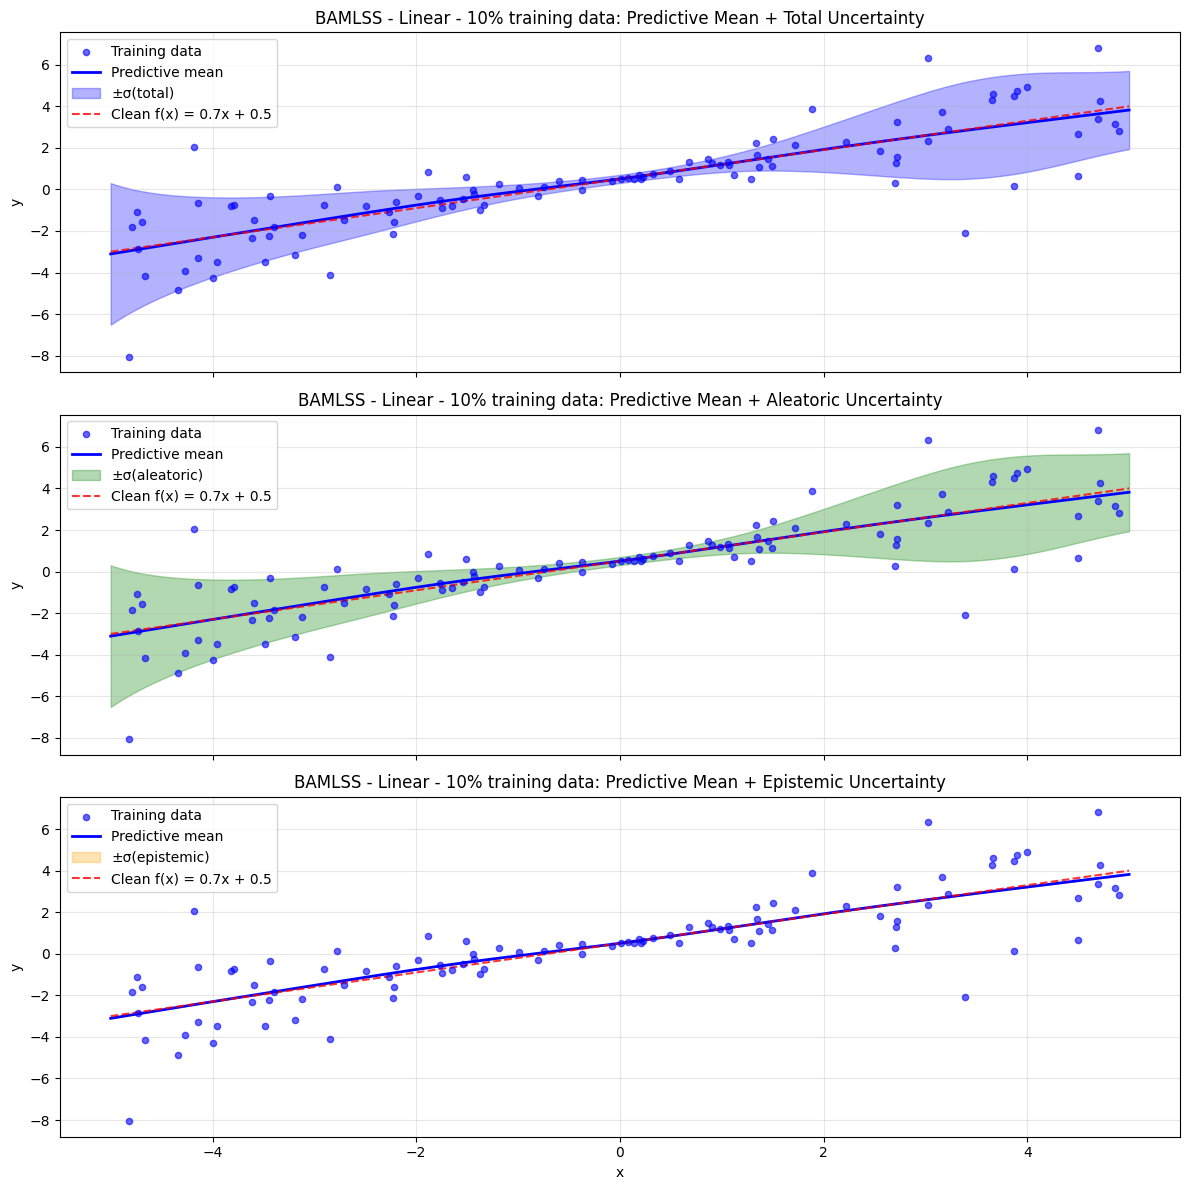


Normalized Average Uncertainties by Percentage - Linear Function

Percentage   Avg Aleatoric (norm)      Avg Epistemic (norm)      Avg Total (norm)          Correlation (Epi-Ale)    
------------------------------------------------------------------------------------------------------------------------
 10%                        0.201941                  0.091671                  0.293613                  0.474121

Note: Average values are normalized to [0, 1] range across all percentages
      Correlation is computed on original (non-normalized) uncertainty values
Saved statistics (CSV): c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods-1\results\sample_size\statistics\heteroscedastic\linear\BAMLSS_uncertainties_summary_Linear_heteroscedastic.csv
Saved statistics (Excel): c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods-1\results\sample_size\statistics\het

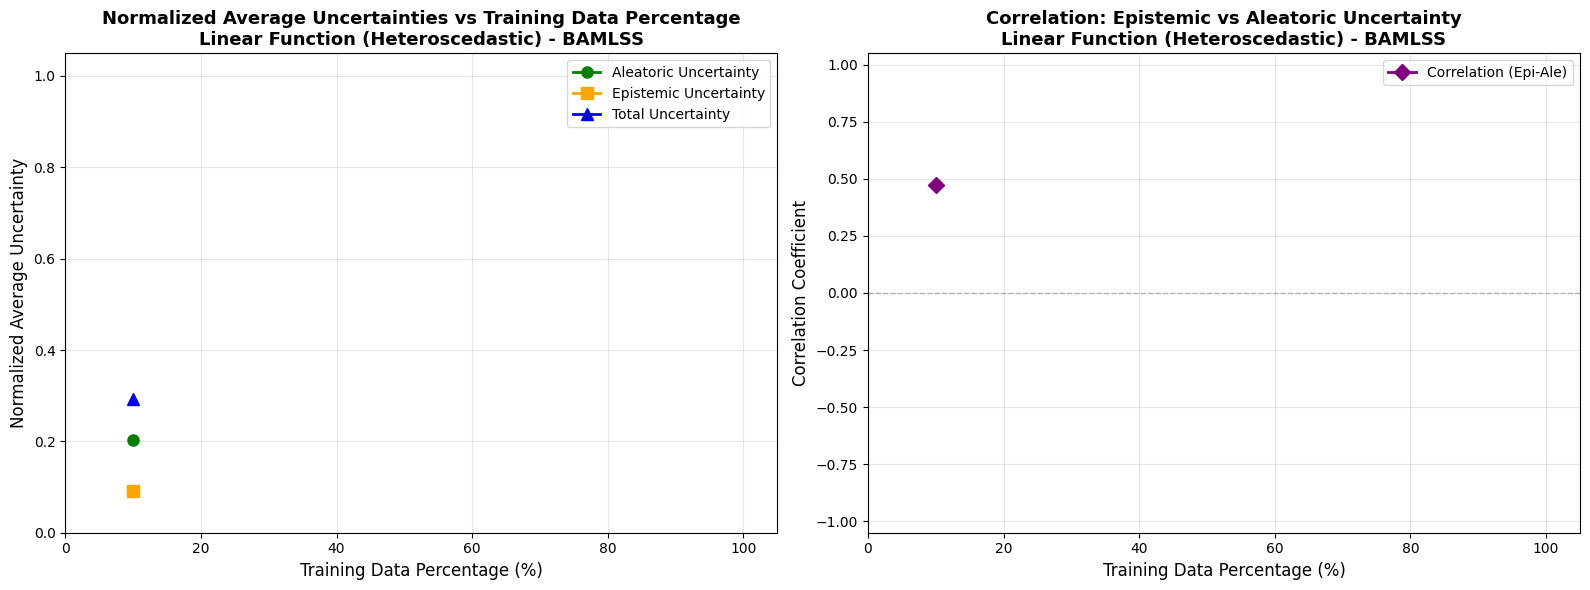


################################################################################
# Function Type: Sinusoidal (sin) - BAMLSS
################################################################################


Training with 10% of training data (100 samples)
Fitting BAMLSS model (this may take a while: 12000 iterations)...
AICc 284.4428 logPost -101.148 logLik -125.445 edf 14.222 eps 0.0001 iteration  12
elapsed time:  0.67sec
|********************| 100%                |   0%  1.60min  1.17min  3.68sec  1.08min  7.19sec  1.08min 11.44sec 58.84sec 14.71sec 54.54sec 18.18sec 50.61sec 21.69sec 45.83sec 24.68sec 42.08sec 28.05sec 38.73sec 31.69sec 36.18sec 36.18sec 33.66sec 41.14sec 29.59sec 44.38sec 25.91sec 48.11sec 22.29sec 52.00sec 18.83sec 56.49sec 15.99sec  1.07min 12.81sec  1.21min  8.51sec  1.28min  4.24sec  1.34min  0.00sec  1.40min
Extracting 1000 posterior samples...
[1] "predict() returned means (shape 600 x 1 ), not samples. Extracting from chain..."
[1] "Extracting samples from

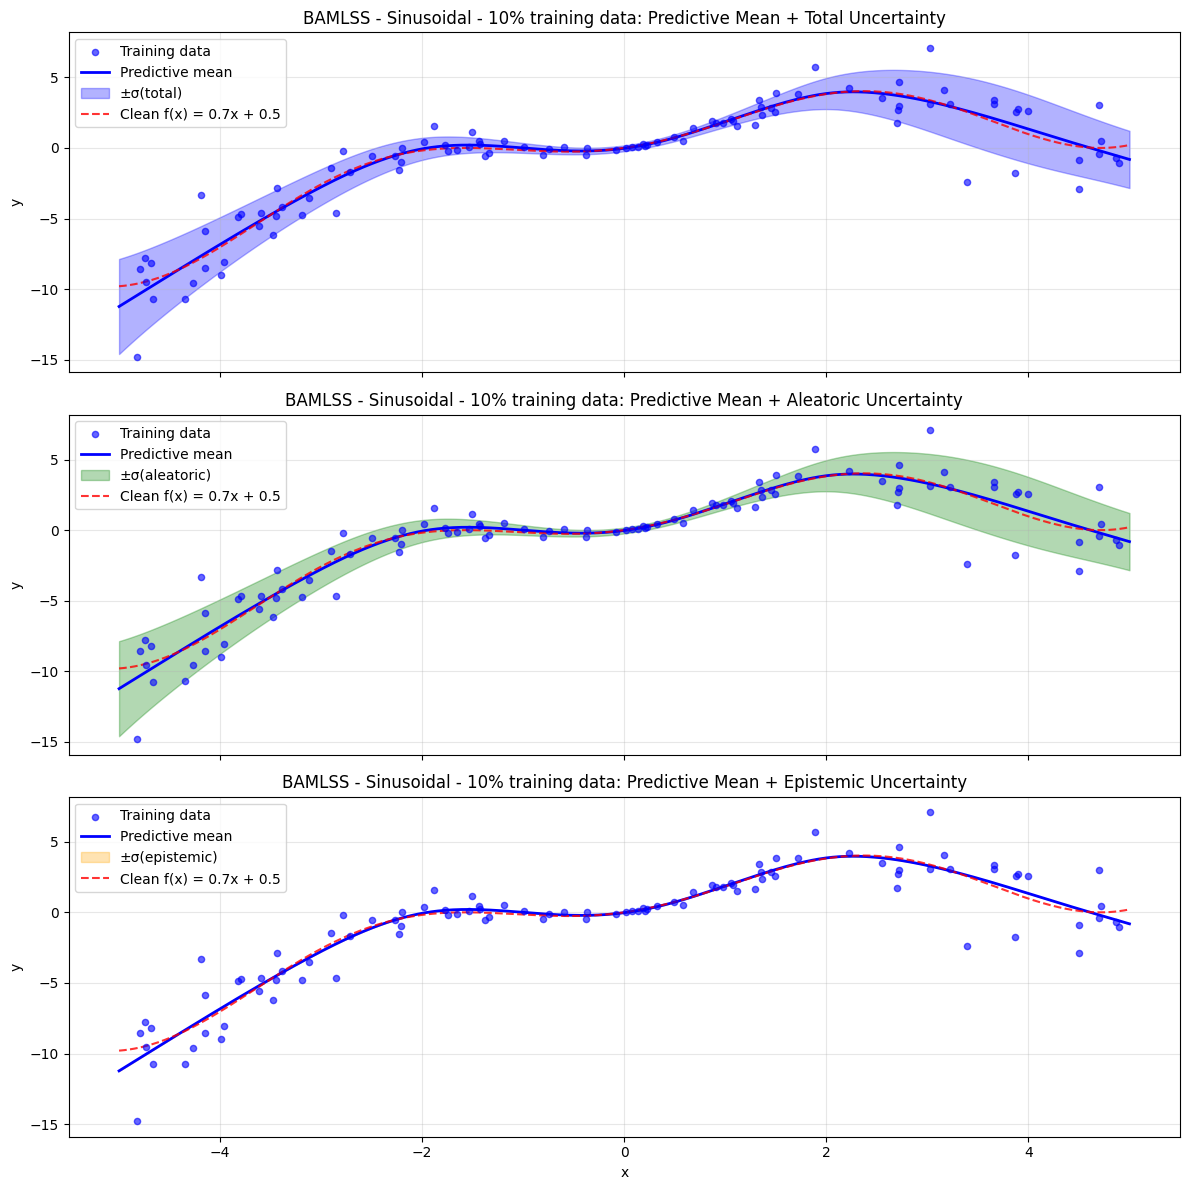


Normalized Average Uncertainties by Percentage - Sinusoidal Function

Percentage   Avg Aleatoric (norm)      Avg Epistemic (norm)      Avg Total (norm)          Correlation (Epi-Ale)    
------------------------------------------------------------------------------------------------------------------------
 10%                        0.212742                  0.033029                  0.245771                  0.457607

Note: Average values are normalized to [0, 1] range across all percentages
      Correlation is computed on original (non-normalized) uncertainty values
Saved statistics (CSV): c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods-1\results\sample_size\statistics\heteroscedastic\sin\BAMLSS_uncertainties_summary_Sinusoidal_heteroscedastic.csv
Saved statistics (Excel): c:\Users\lukas\OneDrive\Desktop\Code-Masterarbeit\A-statistical-evaluation-of-uncertainty-disentanglement-methods-1\results\sample_size\statistic

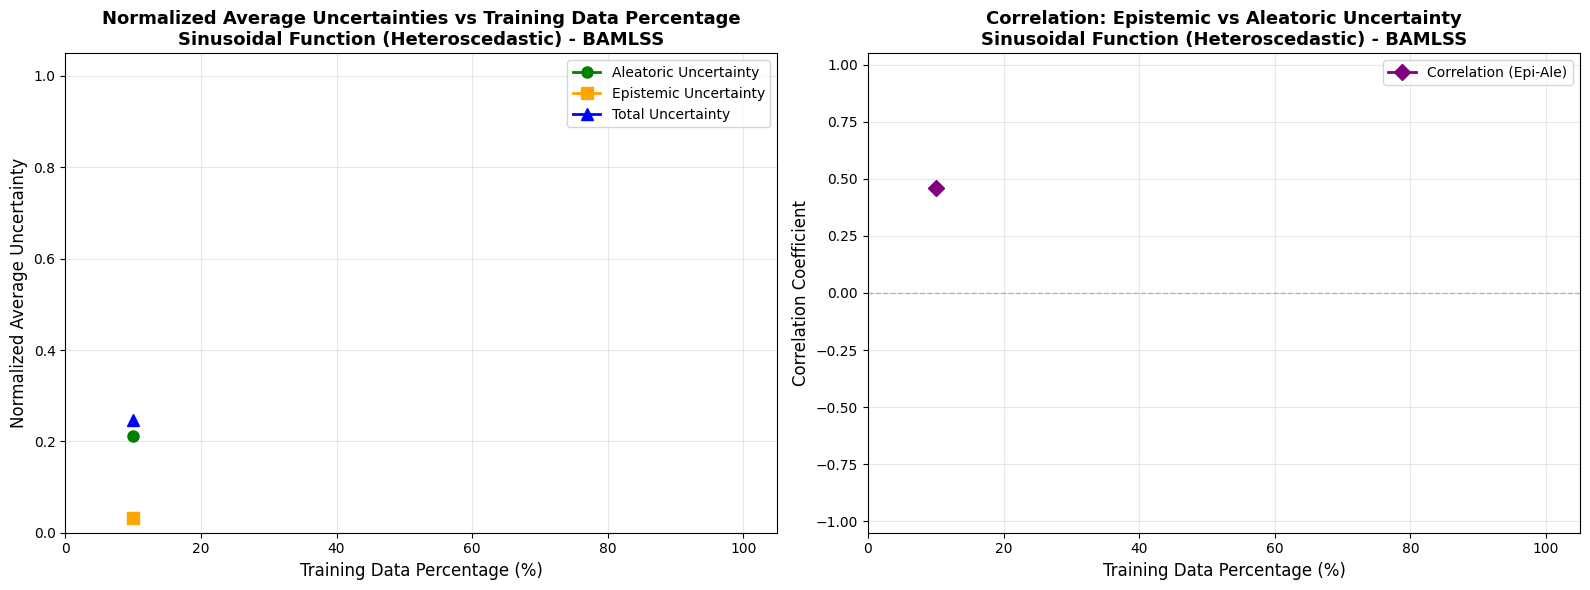

In [ ]:
# Loop through different function types: linear, sin
function_types = ["linear", "sin"]
function_names = {"linear": "Linear", "sin": "Sinusoidal"}

for func_type in function_types:
    print(f"\n{'#'*80}")
    print(f"# Function Type: {function_names[func_type]} ({func_type}) - BAMLSS")
    print(f"{'#'*80}\n")
    
    # Loop through different training data amounts: 1%, 5%, 10%, 15%, 25%, 50%, 100%
    # Generate full training dataset using generate_toy_regression function
    np.random.seed(42)

    # Generate training dataset
    x_train_full, y_train_full, x_grid, y_grid_clean = generate_toy_regression(
        n_train=1000, 
        train_range=(-5, 10), 
        grid_points=1000,
        noise_type='heteroscedastic',
        type=func_type
    )

    # Training data percentages to test
    percentages = [5, 10, 15, 25, 50, 100]
      
    # Main loop: train and evaluate for each percentage
    n_train_full = len(x_train_full)

    # Store uncertainties for each percentage
    uncertainties_by_pct = {pct: {'ale': [], 'epi': [], 'tot': []} for pct in percentages}

    for pct in percentages:
        print(f"\n{'='*60}")
        print(f"Training with {pct}% of training data ({int(n_train_full * pct / 100)} samples)")
        print(f"{'='*60}")
        
        # Set seed for reproducibility of subsampling
        np.random.seed(42)
        
        # Subsample training data
        n_samples = int(n_train_full * pct / 100)
        indices = np.random.choice(n_train_full, size=n_samples, replace=False)
        x_train_subset = x_train_full[indices]
        y_train_subset = y_train_full[indices]
        
        # BAMLSS fits directly - no normalization or training loop needed
        # Make predictions (fitting happens inside bamlss_predict)
        mu_pred, ale_var, epi_var, tot_var = bamlss_predict(
            x_train_subset, y_train_subset, x_grid,
            n_iter=12000, burnin=2000, thin=10, nsamples=1000
        )
        
        # Store uncertainties (using variance values)
        uncertainties_by_pct[pct]['ale'].append(ale_var)
        uncertainties_by_pct[pct]['epi'].append(epi_var)
        uncertainties_by_pct[pct]['tot'].append(tot_var)
        
        # Plot uncertainties
        plot_uncertainties_no_ood(x_train_subset, y_train_subset, x_grid, y_grid_clean, 
                                 mu_pred, ale_var, epi_var, tot_var, 
                                 title=f"BAMLSS - {function_names[func_type]} - {pct}% training data",
                                 noise_type='heteroscedastic', func_type=func_type)
    

    # Normalize and compute averages for each percentage
    print(f"\n{'='*60}")
    print(f"Normalized Average Uncertainties by Percentage - {function_names[func_type]} Function")
    print(f"{'='*60}")

    # First, collect all values to compute global min/max for normalization
    all_ale = np.concatenate([np.concatenate(uncertainties_by_pct[pct]['ale']) for pct in percentages])
    all_epi = np.concatenate([np.concatenate(uncertainties_by_pct[pct]['epi']) for pct in percentages])
    

    # Compute min and max for normalization
    ale_min, ale_max = all_ale.min(), all_ale.max()
    epi_min, epi_max = all_epi.min(), all_epi.max()
    


    # Normalize function
    def normalize(values, vmin, vmax):
        """Normalize values to [0, 1] range"""
        if vmax - vmin == 0:
            return np.zeros_like(values)
        return (values - vmin) / (vmax - vmin)

    # Compute and print normalized averages and correlations for each percentage
    print(f"\n{'Percentage':<12} {'Avg Aleatoric (norm)':<25} {'Avg Epistemic (norm)':<25} {'Avg Total (norm)':<25} {'Correlation (Epi-Ale)':<25}")
    print("-" * 120)

    # Store averages and correlations for plotting
    avg_ale_norm_list = []
    avg_epi_norm_list = []
    avg_tot_norm_list = []
    correlation_list = []

    for pct in percentages:
        # Get uncertainties for this percentage
        ale_vals = np.concatenate(uncertainties_by_pct[pct]['ale'])
        epi_vals = np.concatenate(uncertainties_by_pct[pct]['epi'])
        tot_vals = np.concatenate(uncertainties_by_pct[pct]['tot'])
        
        # Normalize
        ale_norm = normalize(ale_vals, ale_min, ale_max)
        epi_norm = normalize(epi_vals, epi_min, epi_max)
        tot_norm = ale_norm + epi_norm
        
        # Compute averages
        avg_ale_norm = np.mean(ale_norm)
        avg_epi_norm = np.mean(epi_norm)
        avg_tot_norm = np.mean(tot_norm)
        
        # Compute correlation between epistemic and aleatoric uncertainties
        # Use original (non-normalized) values for correlation
        correlation = np.corrcoef(epi_vals, ale_vals)[0, 1]
        if np.isnan(correlation):
            correlation = 0.0  # Handle case where std is zero
        
        # Store for plotting
        avg_ale_norm_list.append(avg_ale_norm)
        avg_epi_norm_list.append(avg_epi_norm)
        avg_tot_norm_list.append(avg_tot_norm)
        correlation_list.append(correlation)
        
        print(f"{pct:>3}%        {avg_ale_norm:>24.6f}  {avg_epi_norm:>24.6f}  {avg_tot_norm:>24.6f}  {correlation:>24.6f}")

    print(f"\n{'='*60}")
    print("Note: Average values are normalized to [0, 1] range across all percentages")
    print("      Correlation is computed on original (non-normalized) uncertainty values")
    print(f"{'='*60}")

    # Save summary statistics and create summary plot
    stats_df, fig = save_summary_statistics(
        percentages, avg_ale_norm_list, avg_epi_norm_list, 
        avg_tot_norm_list, correlation_list, 
        function_names[func_type], 
        noise_type='heteroscedastic',
        func_type=func_type,
        model_name='BAMLSS'
    )
    plt.show()
    plt.close(fig)



## Sample size Homoscedastic - BAMLSS



In [ ]:
# Loop through different function types: linear, sin
function_types = ["linear", "sin"]
function_names = {"linear": "Linear", "sin": "Sinusoidal"}

for func_type in function_types:
    print(f"\n{'#'*80}")
    print(f"# Function Type: {function_names[func_type]} ({func_type}) - BAMLSS")
    print(f"{'#'*80}\n")
    
    # Loop through different training data amounts: 1%, 5%, 10%, 15%, 25%, 50%, 100%
    # Generate full training dataset using generate_toy_regression function
    np.random.seed(42)

    # Generate training dataset
    x_train_full, y_train_full, x_grid, y_grid_clean = generate_toy_regression(
        n_train=1000, 
        train_range=(-5, 10), 
        grid_points=1000,
        noise_type='homoscedastic',
        type=func_type
    )

    # Training data percentages to test
    percentages = [5, 10, 15, 25, 50, 100]
      
    # Main loop: train and evaluate for each percentage
    n_train_full = len(x_train_full)

    # Store uncertainties for each percentage
    uncertainties_by_pct = {pct: {'ale': [], 'epi': [], 'tot': []} for pct in percentages}

    for pct in percentages:
        print(f"\n{'='*60}")
        print(f"Training with {pct}% of training data ({int(n_train_full * pct / 100)} samples)")
        print(f"{'='*60}")
        
        # Set seed for reproducibility of subsampling
        np.random.seed(42)
        
        # Subsample training data
        n_samples = int(n_train_full * pct / 100)
        indices = np.random.choice(n_train_full, size=n_samples, replace=False)
        x_train_subset = x_train_full[indices]
        y_train_subset = y_train_full[indices]
        
        # BAMLSS fits directly - no normalization or training loop needed
        # Make predictions (fitting happens inside bamlss_predict)
        mu_pred, ale_var, epi_var, tot_var = bamlss_predict(
            x_train_subset, y_train_subset, x_grid,
            n_iter=12000, burnin=2000, thin=10, nsamples=1000
        )
        
        # Store uncertainties (using variance values)
        uncertainties_by_pct[pct]['ale'].append(ale_var)
        uncertainties_by_pct[pct]['epi'].append(epi_var)
        uncertainties_by_pct[pct]['tot'].append(tot_var)
        
        # Plot uncertainties
        plot_uncertainties_no_ood(x_train_subset, y_train_subset, x_grid, y_grid_clean, 
                                 mu_pred, ale_var, epi_var, tot_var, 
                                 title=f"BAMLSS - {function_names[func_type]} - {pct}% training data",
                                 noise_type='homoscedastic', func_type=func_type)
    

    # Normalize and compute averages for each percentage
    print(f"\n{'='*60}")
    print(f"Normalized Average Uncertainties by Percentage - {function_names[func_type]} Function")
    print(f"{'='*60}")

    # First, collect all values to compute global min/max for normalization
    all_ale = np.concatenate([np.concatenate(uncertainties_by_pct[pct]['ale']) for pct in percentages])
    all_epi = np.concatenate([np.concatenate(uncertainties_by_pct[pct]['epi']) for pct in percentages])
    all_tot = np.concatenate([np.concatenate(uncertainties_by_pct[pct]['tot']) for pct in percentages])

    # Compute min and max for normalization
    ale_min, ale_max = all_ale.min(), all_ale.max()
    epi_min, epi_max = all_epi.min(), all_epi.max()
    tot_min, tot_max = all_tot.min(), all_tot.max()

    # Normalize function
    def normalize(values, vmin, vmax):
        """Normalize values to [0, 1] range"""
        if vmax - vmin == 0:
            return np.zeros_like(values)
        return (values - vmin) / (vmax - vmin)

    # Compute and print normalized averages and correlations for each percentage
    print(f"\n{'Percentage':<12} {'Avg Aleatoric (norm)':<25} {'Avg Epistemic (norm)':<25} {'Avg Total (norm)':<25} {'Correlation (Epi-Ale)':<25}")
    print("-" * 120)

    # Store averages and correlations for plotting
    avg_ale_norm_list = []
    avg_epi_norm_list = []
    avg_tot_norm_list = []
    correlation_list = []

    for pct in percentages:
        # Get uncertainties for this percentage
        ale_vals = np.concatenate(uncertainties_by_pct[pct]['ale'])
        epi_vals = np.concatenate(uncertainties_by_pct[pct]['epi'])
        tot_vals = np.concatenate(uncertainties_by_pct[pct]['tot'])
        
        # Normalize
        ale_norm = normalize(ale_vals, ale_min, ale_max)
        epi_norm = normalize(epi_vals, epi_min, epi_max)
        tot_norm = normalize(tot_vals, tot_min, tot_max)
        
        # Compute averages
        avg_ale_norm = np.mean(ale_norm)
        avg_epi_norm = np.mean(epi_norm)
        avg_tot_norm = np.mean(tot_norm)
        
        # Compute correlation between epistemic and aleatoric uncertainties
        # Use original (non-normalized) values for correlation
        correlation = np.corrcoef(epi_vals, ale_vals)[0, 1]
        if np.isnan(correlation):
            correlation = 0.0  # Handle case where std is zero
        
        # Store for plotting
        avg_ale_norm_list.append(avg_ale_norm)
        avg_epi_norm_list.append(avg_epi_norm)
        avg_tot_norm_list.append(avg_tot_norm)
        correlation_list.append(correlation)
        
        print(f"{pct:>3}%        {avg_ale_norm:>24.6f}  {avg_epi_norm:>24.6f}  {avg_tot_norm:>24.6f}  {correlation:>24.6f}")

    print(f"\n{'='*60}")
    print("Note: Average values are normalized to [0, 1] range across all percentages")
    print("      Correlation is computed on original (non-normalized) uncertainty values")
    print(f"{'='*60}")

    # Save summary statistics and create summary plot
    stats_df, fig = save_summary_statistics(
        percentages, avg_ale_norm_list, avg_epi_norm_list, 
        avg_tot_norm_list, correlation_list, 
        function_names[func_type], 
        noise_type='homoscedastic',
        func_type=func_type,
        model_name='BAMLSS'
    )
    plt.show()
    plt.close(fig)

